In [70]:
import os
import re
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import typing as t

pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.data.claims_denials import (
    get_overturn_rate,
    get_overturn_rates_by_categorical_col,
)
from src.utils.download import download_file_from_url
from src.utils.plot import plot_bar, plot_hist, plot_pie

INPUT_DATA_DIR = "./input_data"
OUTPUT_IMAGE_DIR = "./images/ca_doi_external_appeals"
OUTPUT_DATA_DIR = "./output_data/ca_doi_external_appeals"  # Set to None if you don't want to save optional data for external use
NO_PLOT_TITLES = False  # If True, plots have no titles. Useful for cases where one wants titles rendered separately from underlying plots.

In [71]:
os.makedirs(INPUT_DATA_DIR, exist_ok=True)
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

In [72]:
# DOI yearly report:
# https://www.insurance.ca.gov/0400-news/0200-studies-reports/0700-commissioner-report/upload/2021Annual-Report-of-the-Insurance-Commissioner.pdf

# DMHC yearly report
# https://dmhc.ca.gov/AbouttheDMHC/DMHCReports/AnnualReports.aspx

# HHS page for IMR determinations from Department of Managed Health Care (applies to HMO IMR appeals)
# https://data.chhs.ca.gov/dataset/independent-medical-review-imr-determinations-trend

# CA DOI, same data for decisions sent to CA department of Insurance.
# Different format, why god :0
# https://interactive.web.insurance.ca.gov/apex_extprd/f?p=192:1:1847478466984:::::

### DOI Data


In [73]:
url = "https://interactive.web.insurance.ca.gov/apex_extprd/f?p=192:4:15780617087096:CSV:NO:RP::"
doi_imr_data_path = os.path.join(INPUT_DATA_DIR, "ca_doi_imr.csv")
download_file_from_url(url, doi_imr_data_path, legacy_ssl=True)

Target file ./input_data/ca_doi_imr.csv already exists.


In [74]:
df = pd.read_csv(doi_imr_data_path, encoding="ISO-8859-1").sort_values(
    by="Year", ignore_index=True
)

In [75]:
print(f"This dataset contains a total of {len(df)} IMRs administered by CDI.")
for year, count in df["Year"].value_counts(sort=False).items():
    print(f"\t{count} IMRs from {year}")

This dataset contains a total of 4719 IMRs administered by CDI.
	384 IMRs from 2011
	472 IMRs from 2012
	488 IMRs from 2013
	455 IMRs from 2014
	473 IMRs from 2015
	453 IMRs from 2016
	440 IMRs from 2017
	400 IMRs from 2018
	375 IMRs from 2019
	274 IMRs from 2020
	192 IMRs from 2021
	197 IMRs from 2022
	116 IMRs from 2023


In [76]:
# # Remove 2023 records, since claims are still being adjudicated, there are pending internal appeals, etc.
# Yields view of statistics that is inconsistent with methodology for complete years
df = df[df["Year"] != 2023]

In [77]:
def get_overturn_rates_by_category(
    df: pd.DataFrame,
    cat_col: str,
    by_year: bool = False,
    outcome_col: str = "Outcome",
    upheld_cat_name: str = "Insurer Denial Upheld",
    overturned_cat_name: str = "Insurer Denial Overturned",
    year_cat_name: str = "Year",
) -> dict:
    """Given a column in df, specified by cat_col, break down appeal decision outcomes split on distinct values in the column."""
    decision_data = {}
    for val in df[cat_col].unique():
        decision_data[val] = {}
        rel_df = df[df[cat_col] == val]
        overturn_counts = rel_df[outcome_col].value_counts()
        decision_data[val]["overall"] = {}
        overturned = overturn_counts.get(overturned_cat_name, 0)
        decision_data[val]["overall"]["overturned"] = overturned
        decision_data[val]["overall"]["upheld"] = overturn_counts.get(
            upheld_cat_name, 0
        )
        decision_data[val]["overall"]["withdrew"] = overturn_counts.get(
            "Insured Withdrew", 0
        )
        decision_data[val]["overall"]["overturn_rate"] = (
            overturned / overturn_counts.values.sum() if overturned else None
        )

        if by_year:
            for year in rel_df[year_cat_name].unique():
                decision_data[val][year] = {}
                sub_df = rel_df[rel_df[year_cat_name] == year]
                overturn_counts = sub_df[outcome_col].value_counts()
                overturned = overturn_counts.get(overturned_cat_name, 0)
                decision_data[val][year]["upheld"] = overturn_counts.get(
                    upheld_cat_name, 0
                )
                decision_data[val][year]["overturned"] = overturned
                decision_data[val][year]["withdrew"] = overturn_counts.get(
                    "Insured Withdrew", None
                )
                decision_data[val][year]["overturn_rate"] = (
                    overturned / overturn_counts.values.sum() if overturned else None
                )
    return decision_data

In [78]:
def print_appeal_results(appeal_decision_counts):
    bar_names, bar_vals = (
        list(appeal_decision_counts.index),
        appeal_decision_counts.values,
    )
    print(bar_names)
    print(
        f"{int(100* (round(bar_vals[0]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were upheld"
    )
    print(
        f"{int(100* (round(bar_vals[1]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were overturned."
    )
    return None

In [79]:
appeal_decision_counts = df["Outcome"].value_counts()
print_appeal_results(appeal_decision_counts)

['Insurer Denial Upheld', 'Insurer Denial Overturned', 'Insured Withdrew']
50% of all original determinations in external appeals were upheld
49% of all original determinations in external appeals were overturned.


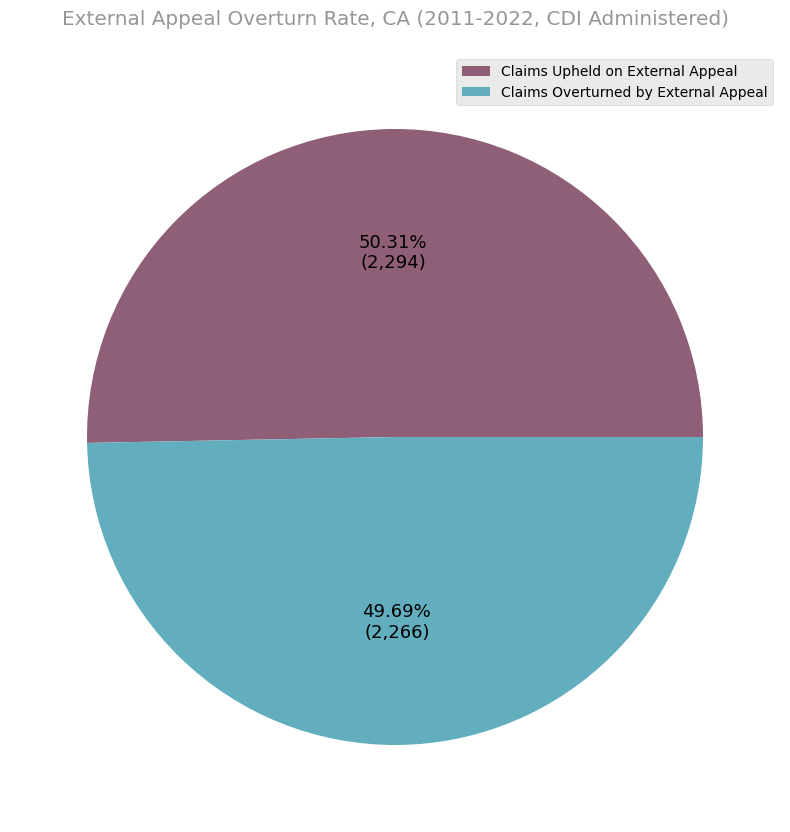

In [80]:
claims_externally_appealed = (
    appeal_decision_counts["Insurer Denial Upheld"]
    + appeal_decision_counts["Insurer Denial Overturned"]
)
claims_externally_overturned = appeal_decision_counts["Insurer Denial Overturned"]
external_appeals_upheld = claims_externally_appealed - claims_externally_overturned
plot_pie(
    slice_names=[
        "Claims Upheld on External Appeal",
        "Claims Overturned by External Appeal",
    ],
    slice_vals=[external_appeals_upheld, claims_externally_overturned],
    title="External Appeal Overturn Rate, CA (2011-2022, CDI Administered)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_success_rates.png"),
    show=True,
)

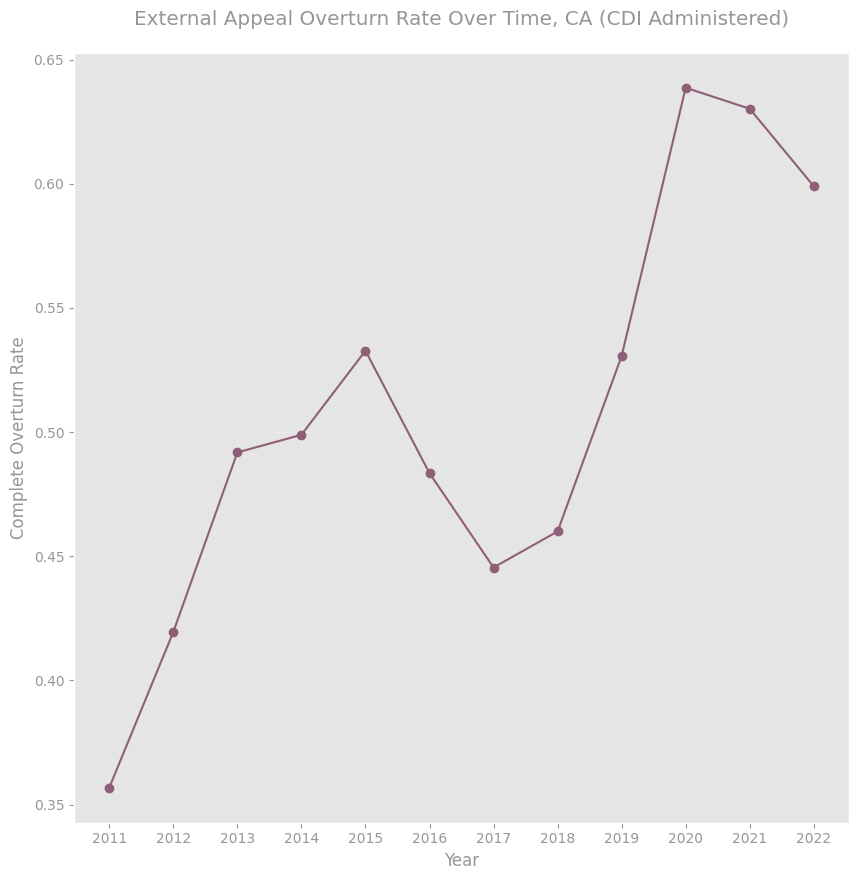

In [81]:
# Plot overall decision rates by year
decision_data = get_overturn_rates_by_category(df, "Year")
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Year"].unique())
if not NO_PLOT_TITLES:
    ax.set_title("External Appeal Overturn Rate Over Time, CA (CDI Administered)")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
timeseries = []
for year in x:
    if decision_data.get(year, None):
        timeseries.append(decision_data[year]["overall"]["overturn_rate"])
    else:
        timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, timeseries, "o-")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

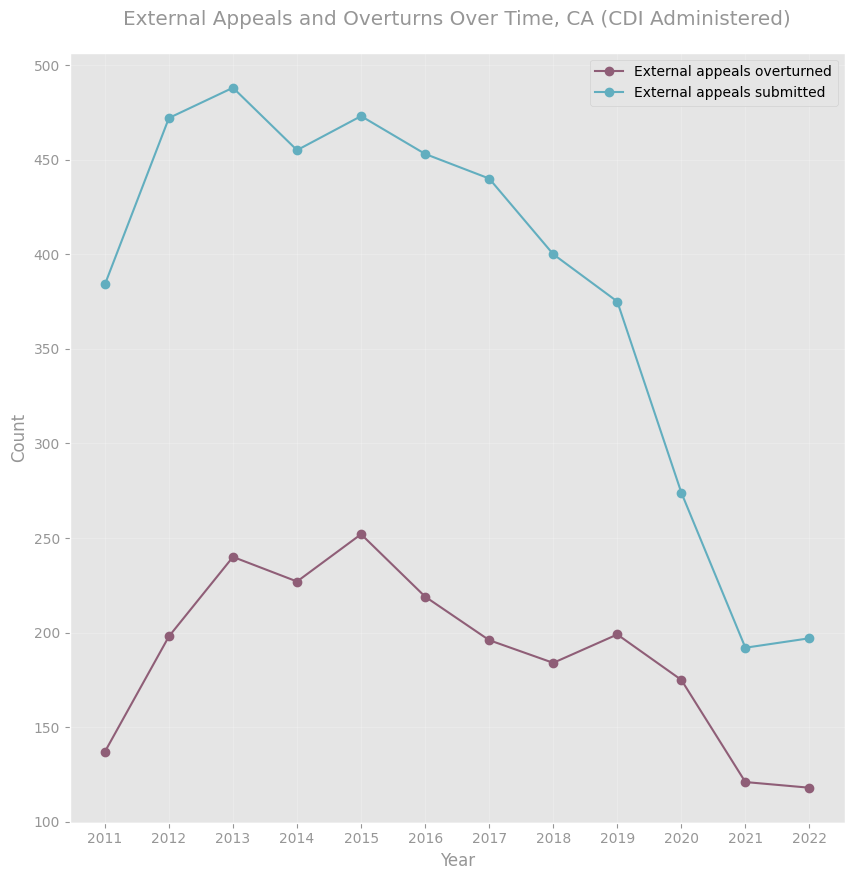

In [82]:
# Plot complete overturns and number of external appeals over same time period, to see what's affecting rate
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Year"].unique())
if not NO_PLOT_TITLES:
    ax.set_title("External Appeals and Overturns Over Time, CA (CDI Administered)")
ax.set_ylabel("Count")
ax.set_xlabel("Year")
appeals_timeseries = []
overturns_timeseries = []
for year in x:
    if decision_data.get(year, None):
        year_data = decision_data[year]["overall"]
        appeals_timeseries.append(
            year_data["overturned"] + year_data["withdrew"] + year_data["upheld"]
        )
        overturns_timeseries.append(year_data["overturned"])
    else:
        appeals_timeseries.append(None)
        overturns_timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, overturns_timeseries, "o-", label="External appeals overturned")
ax.plot(dates, appeals_timeseries, "o-", label="External appeals submitted")
ax.legend(labelcolor="black")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

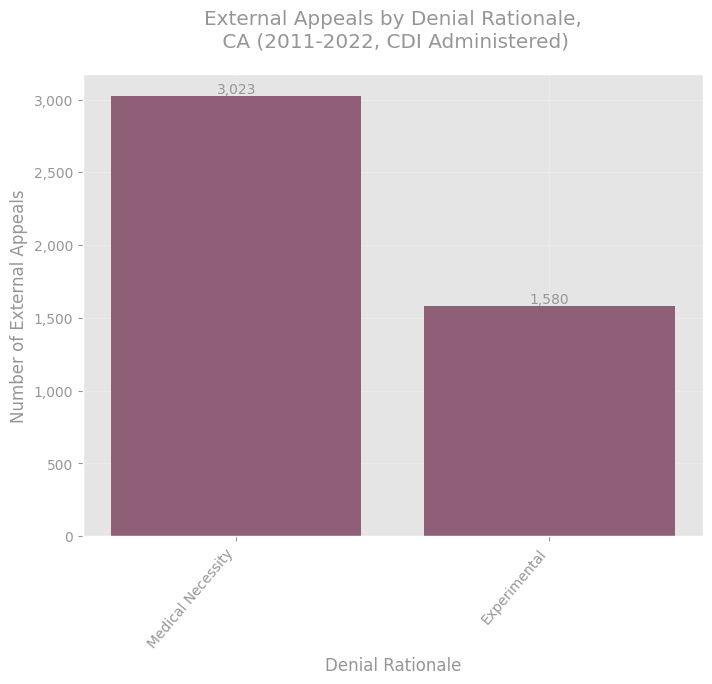

In [83]:
# Breakdown Appeals by Initial Denial Rationale
title = "External Appeals by Denial Rationale,\n CA (2011-2022, CDI Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Denial Rationale"
denial_val_counts = df["IMR Type"].value_counts()
bar_names, bar_vals = list(denial_val_counts.index), denial_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_denial_reason.png"),
    figsize=(8, 6),
)

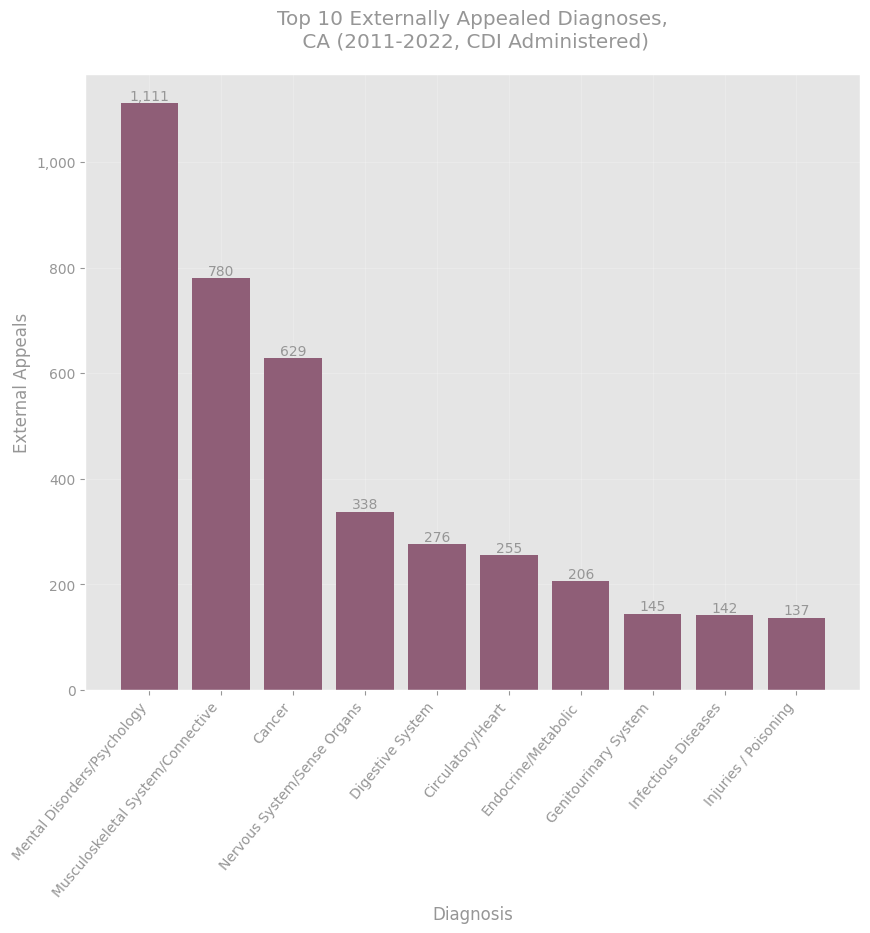

In [84]:
# Diagnosis breakdowns
n = 10
title = f"Top {n} Externally Appealed Diagnoses,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = df["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = list(diagnosis_val_counts.index), diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnoses.png"),
    bar_label=True,
    figsize=(10, 8),
)

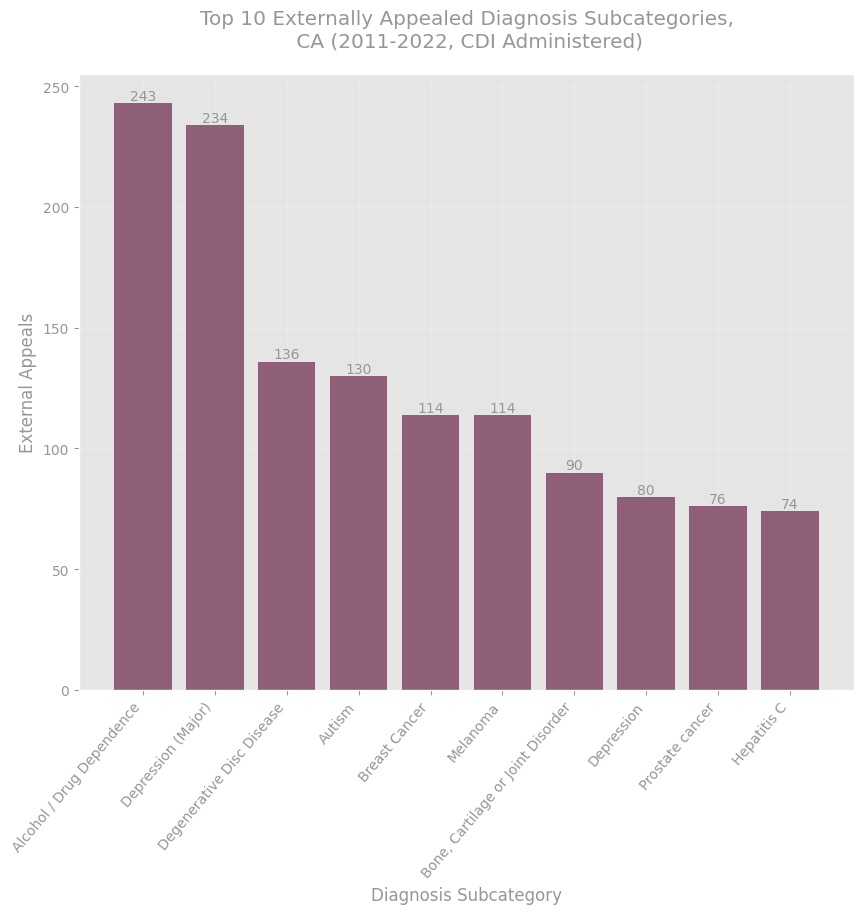

In [85]:
# Diagnosis breakdowns
n = 10
title = f"Top {n} Externally Appealed Diagnosis Subcategories,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis Subcategory"
subdiagnosis_val_counts = df["Diagnosis Subcategory"].value_counts()[:n]
bar_names, bar_vals = (
    list(subdiagnosis_val_counts.index),
    subdiagnosis_val_counts.values,
)
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnosis_subcategories.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

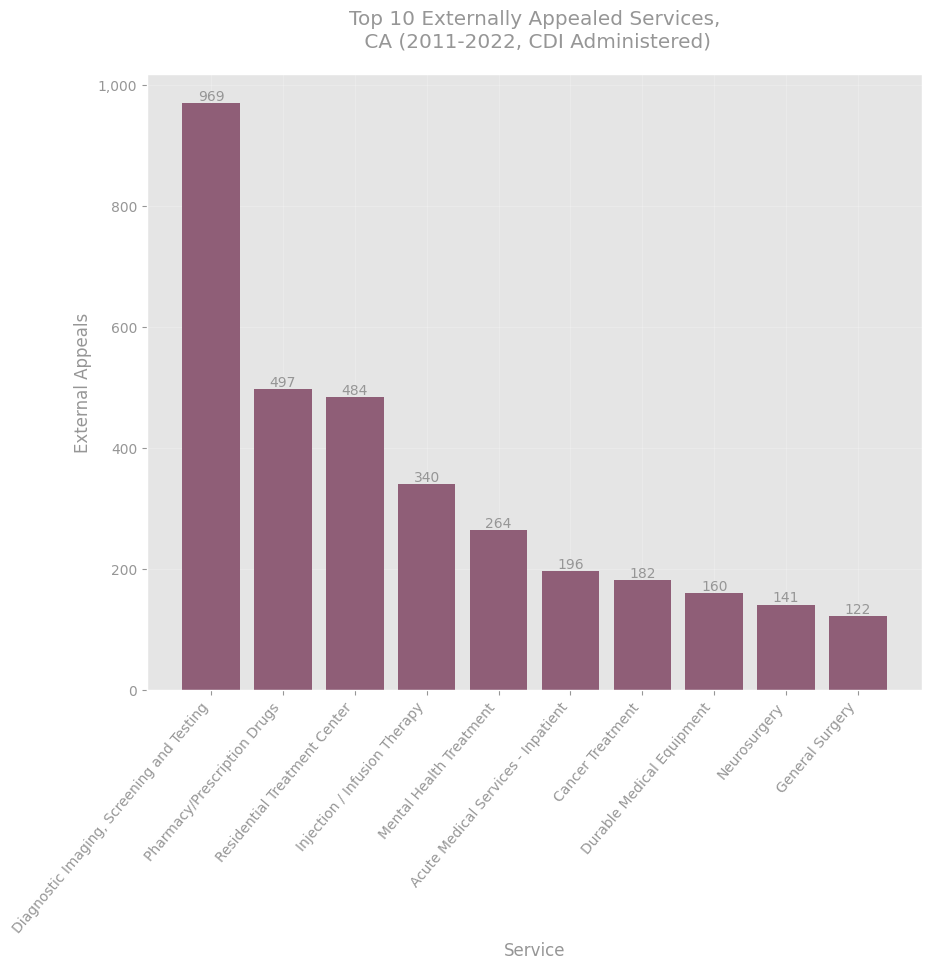

In [86]:
# Service
n = 10
title = f"Top {n} Externally Appealed Services,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Service"
treat_val_counts = df["Treatment"].value_counts()[:n]
bar_names, bar_vals = list(treat_val_counts.index), treat_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_treatments.png"),
    bar_label=True,
    figsize=(10, 8),
)

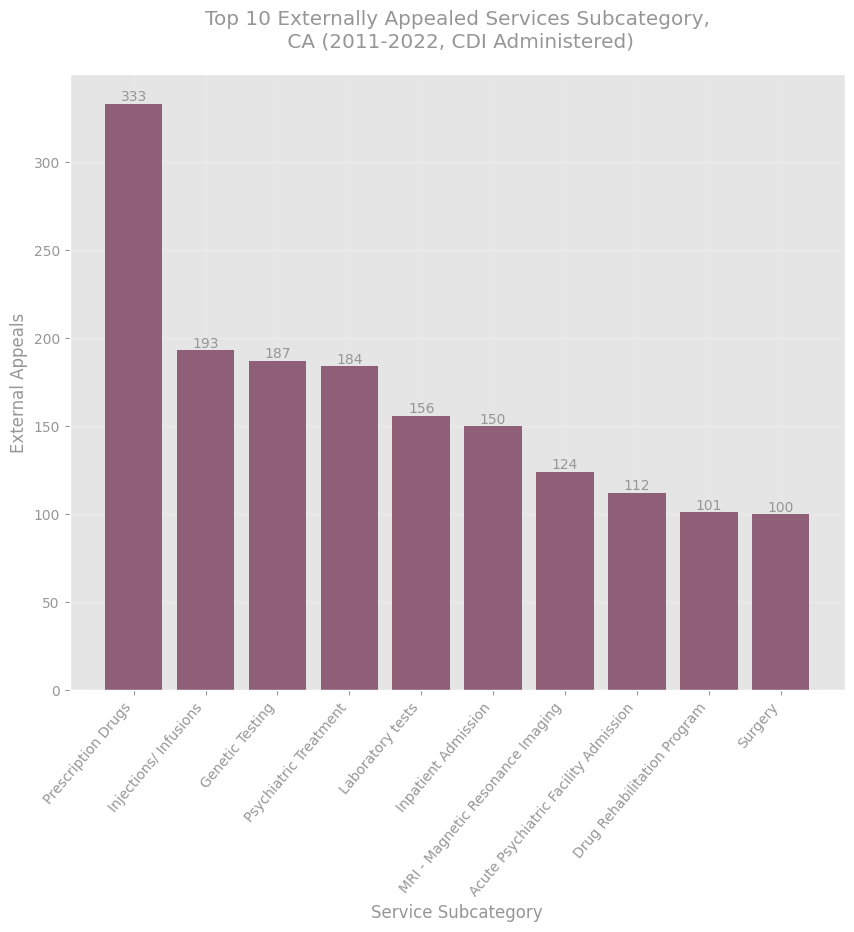

In [87]:
# Sub-Service
n = 10
title = f"Top {n} Externally Appealed Services Subcategory,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Service Subcategory"
treat_val_counts = df["Treatment Subcategory"].value_counts()[:n]
bar_names, bar_vals = list(treat_val_counts.index), treat_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_sub_treatments.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

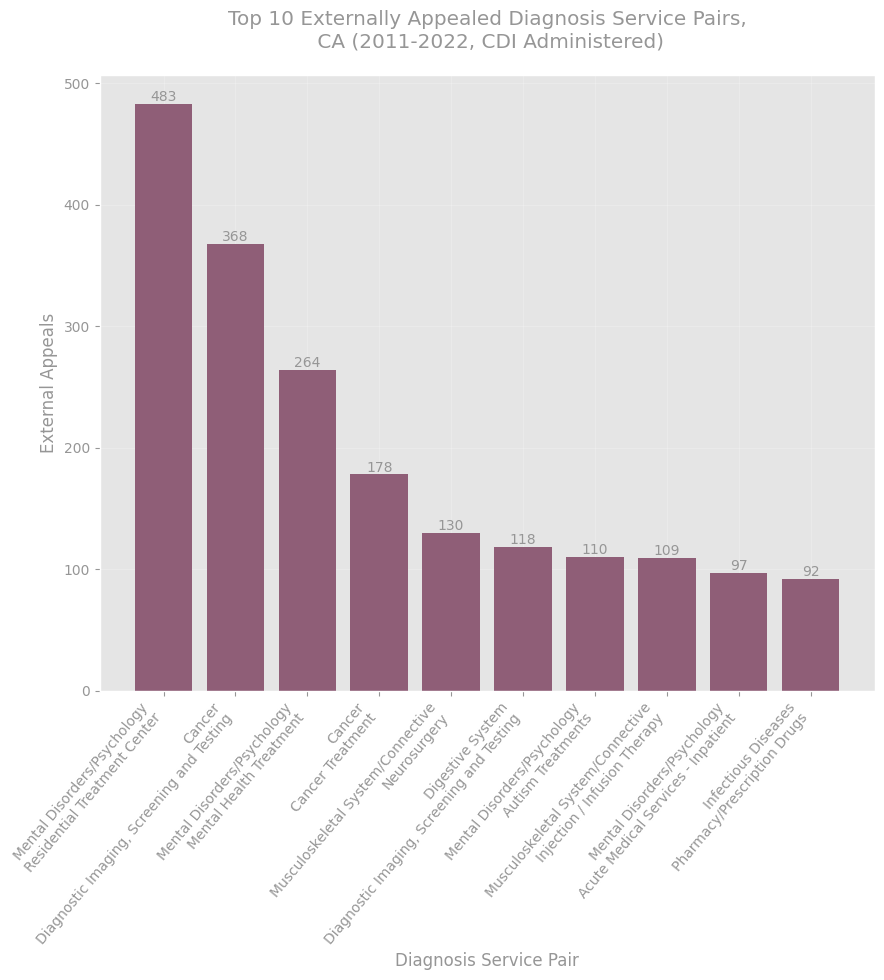

In [88]:
# Service / Diagnosis Pairs
n = 10
title = f"Top {n} Externally Appealed Diagnosis Service Pairs,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis Service Pair"
diag_treat_pairs = (
    df.groupby(["Diagnosis", "Treatment"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0] + "\n" + x[1]
    for x in zip(
        diag_treat_pairs["Diagnosis"].values, diag_treat_pairs["Treatment"].values
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_appealed_diag_services.png"),
    bar_label=True,
    figsize=(10, 8),
)

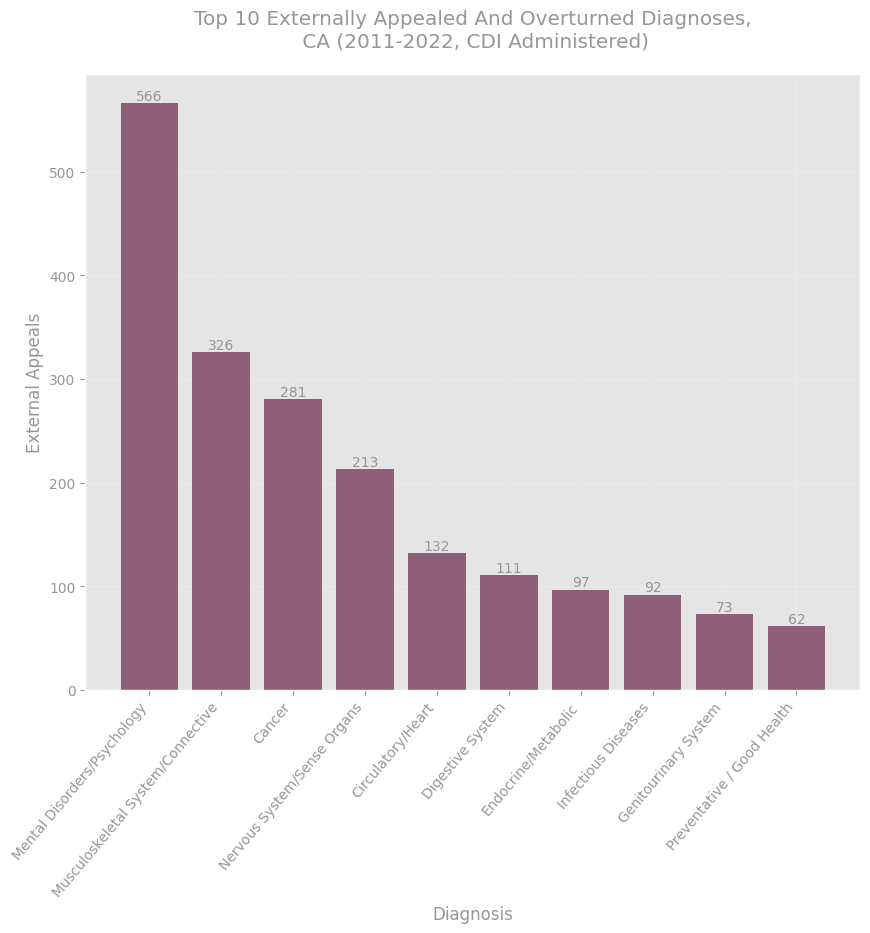

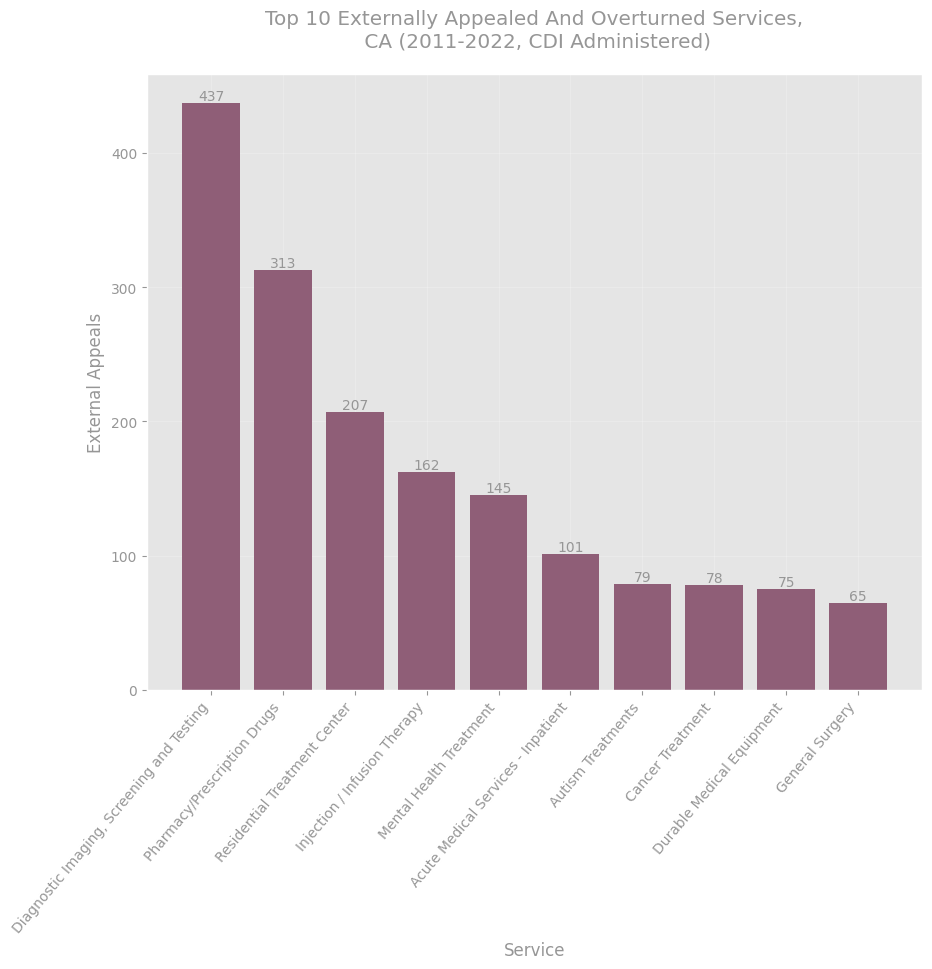

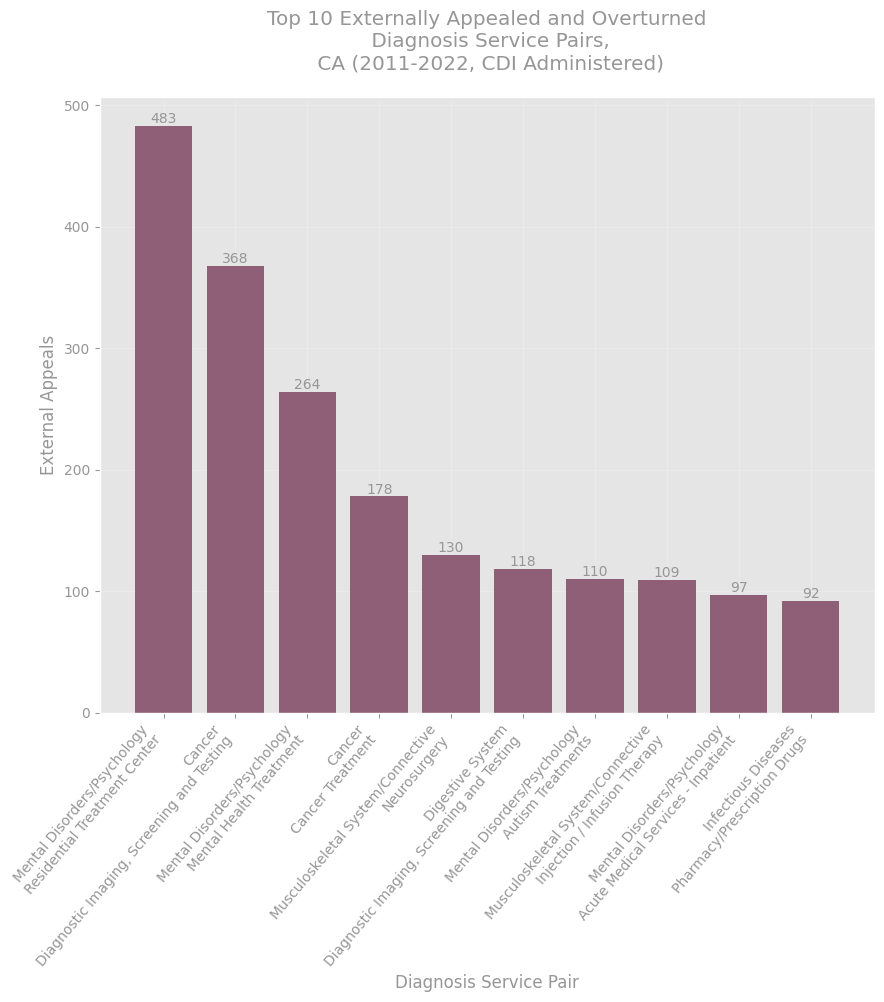

In [89]:
# Top Diagnoses, Services and Pairs for Overturned
overturns = df[df["Outcome"] == "Insurer Denial Overturned"]

# Diagnosis breakdowns
n = 10
title = f"Top {n} Externally Appealed And Overturned Diagnoses,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = overturns["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = list(diagnosis_val_counts.index), diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_overturned_diagnoses.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

# Service
title = f"Top {n} Externally Appealed And Overturned Services,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Service"
treat_val_counts = overturns["Treatment"].value_counts()[:n]
bar_names, bar_vals = list(treat_val_counts.index), treat_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_overturned_treatments.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

# Service / Diagnosis Pairs
title = f"Top {n} Externally Appealed and Overturned\n Diagnosis Service Pairs,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis Service Pair"
diag_treat_pairs = (
    df.groupby(["Diagnosis", "Treatment"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0] + "\n" + x[1]
    for x in zip(
        diag_treat_pairs["Diagnosis"].values, diag_treat_pairs["Treatment"].values
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_overturned_diag_services.png"),
    bar_label=True,
    figsize=(10, 8),
)

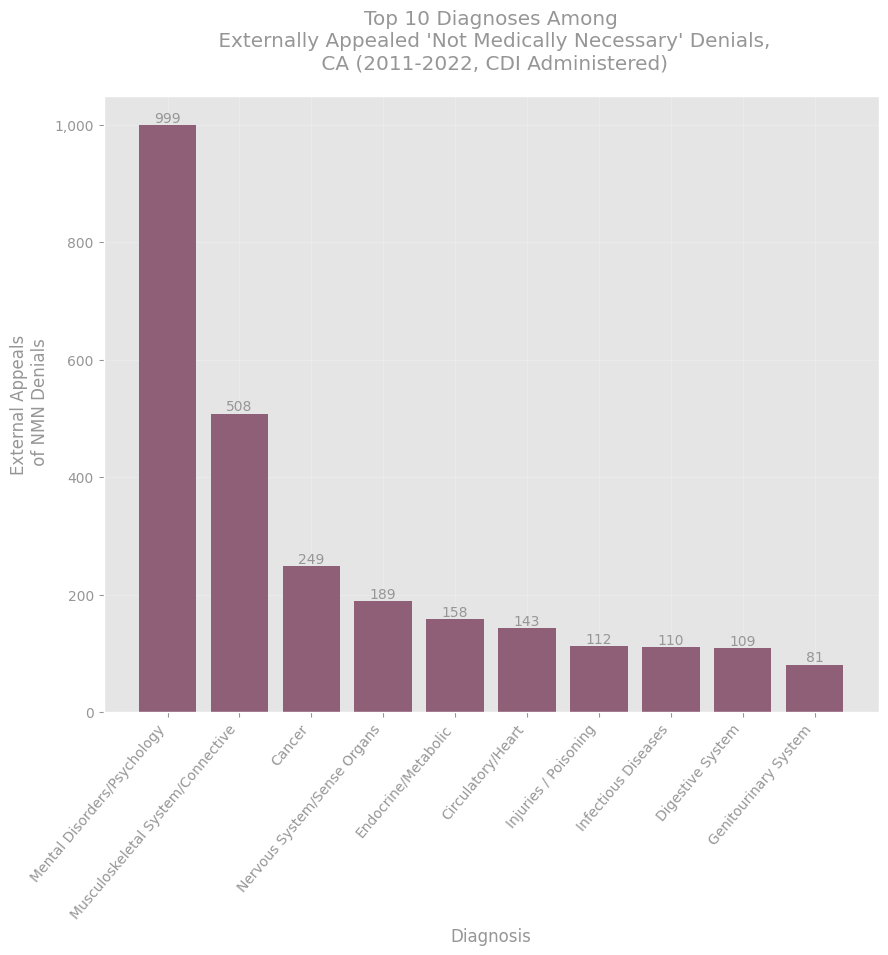

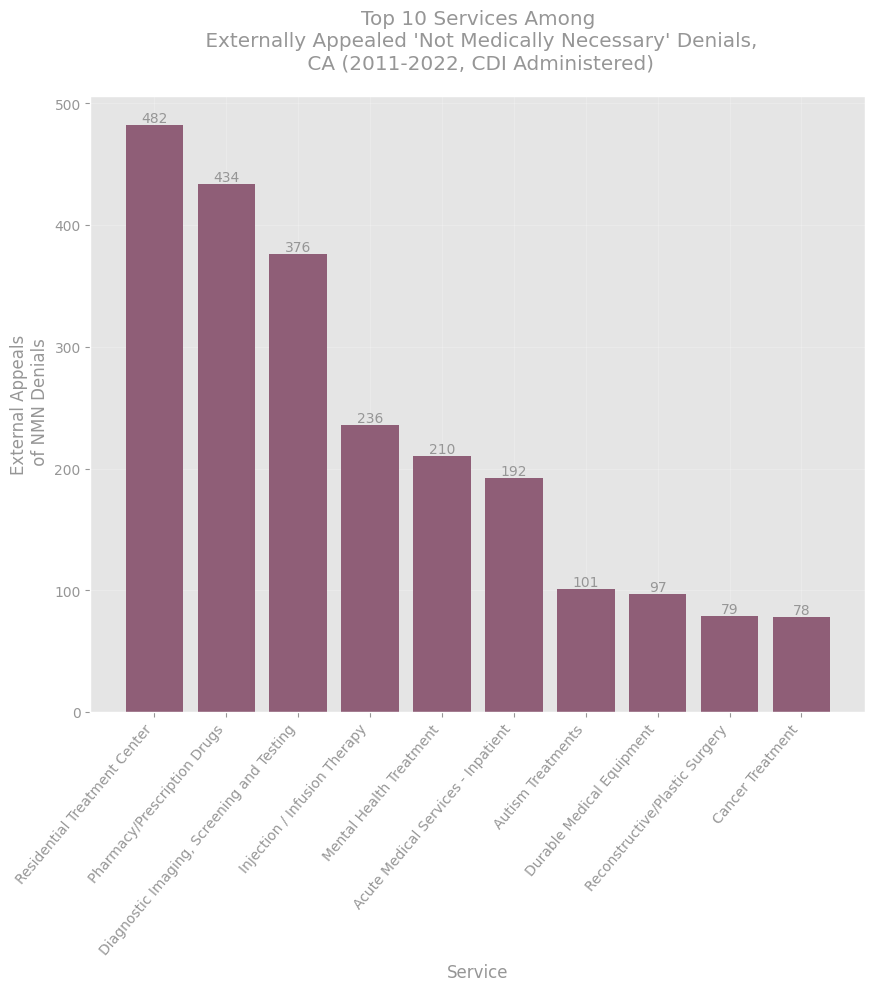

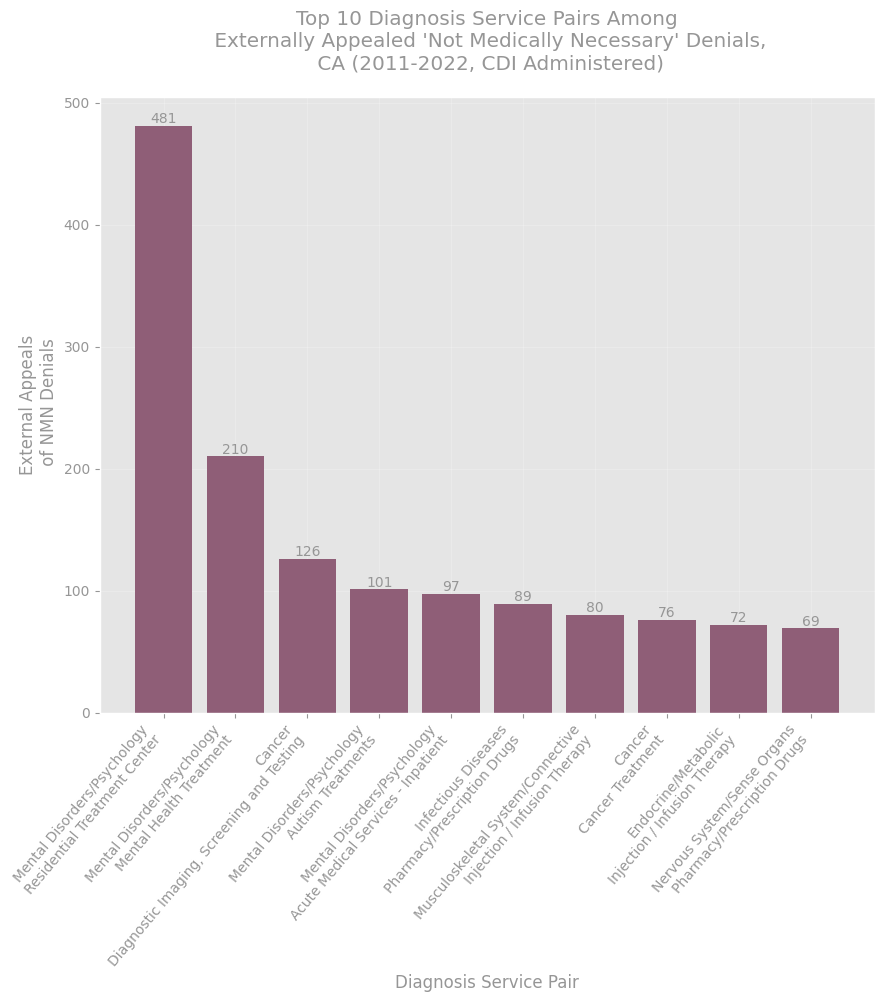

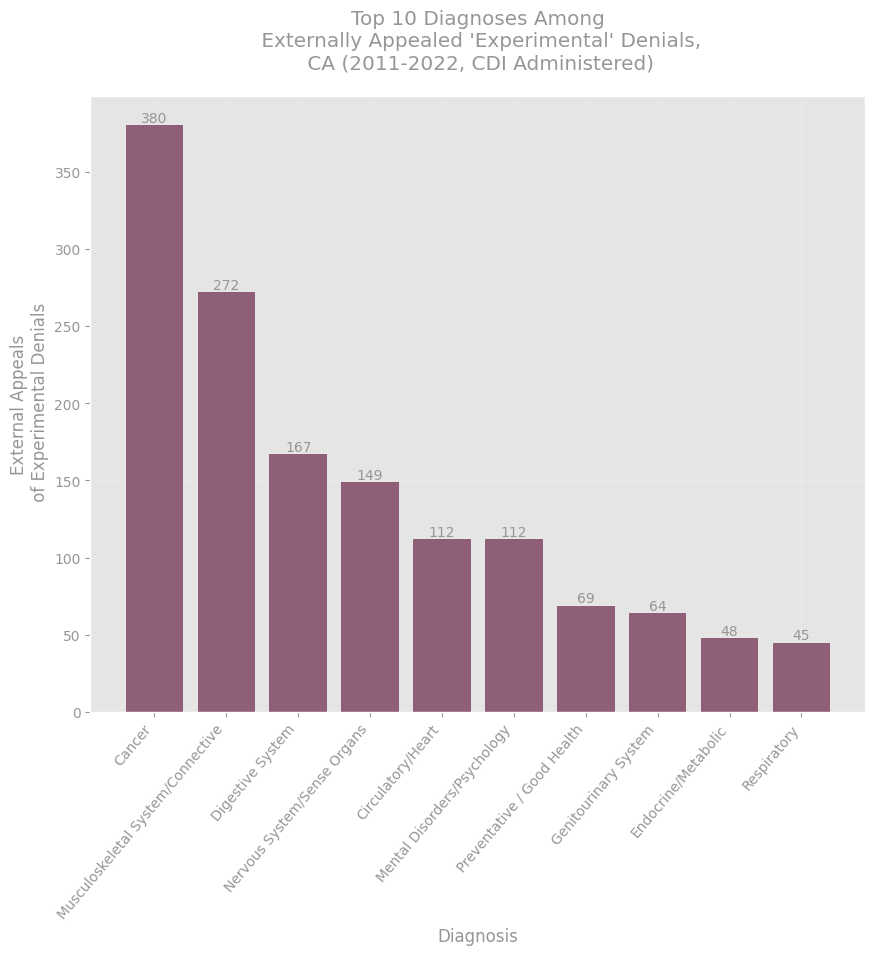

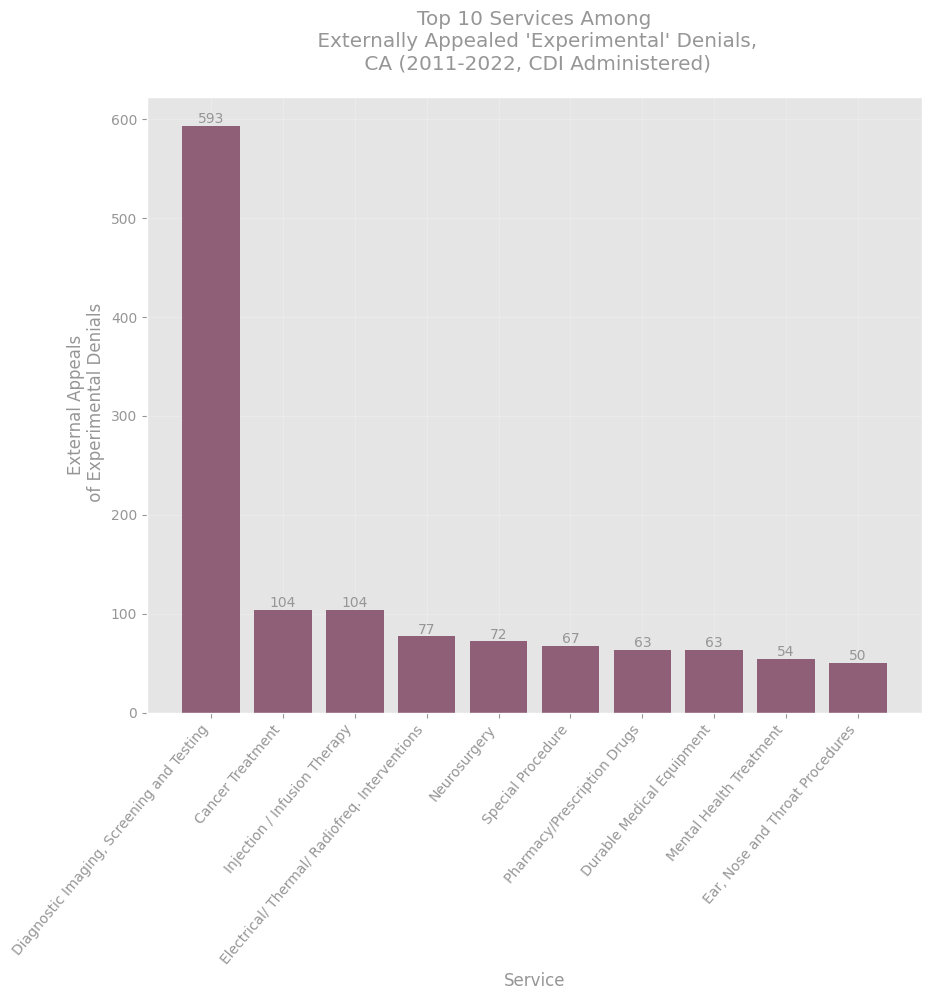

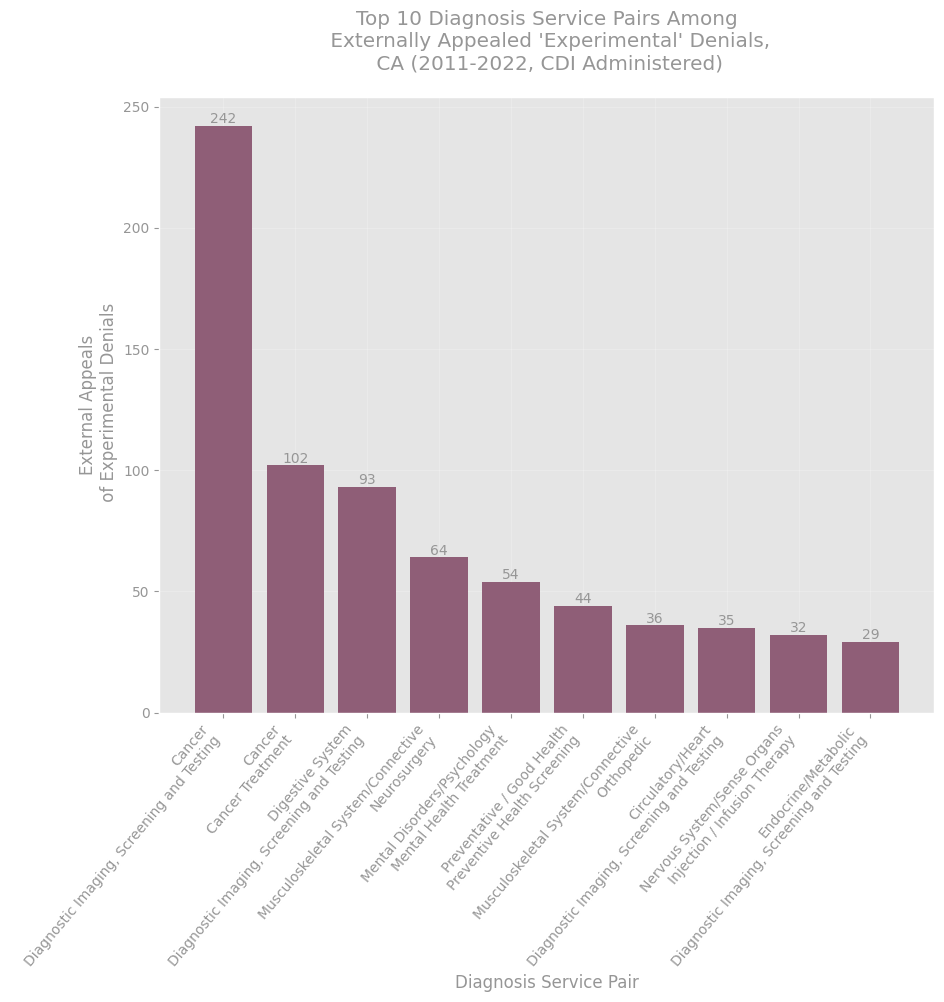

In [90]:
# Top Diagnoses, Services and Pairs for NMN/Experimental Appeals
nmn = df[df["IMR Type"] == "Medical Necessity"]
experimental = df[df["IMR Type"] == "Experimental"]
n = 10

title = f"Top {n} Diagnoses Among\n Externally Appealed 'Not Medically Necessary' Denials,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals\n of NMN Denials"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = nmn["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = list(diagnosis_val_counts.index), diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_nmn_appeal_diagnoses.png"),
    figsize=(10, 8),
    bar_label=True,
)

title = f"Top {n} Services Among\n Externally Appealed 'Not Medically Necessary' Denials,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals\n of NMN Denials"
cat_axis_label = "Service"
service_val_counts = nmn["Treatment"].value_counts()[:n]
bar_names, bar_vals = list(service_val_counts.index), service_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_nmn_appeal_services.png"),
    figsize=(10, 8),
    bar_label=True,
)

title = f"Top {n} Diagnosis Service Pairs Among\n Externally Appealed 'Not Medically Necessary' Denials,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals\n of NMN Denials"
cat_axis_label = "Diagnosis Service Pair"
diag_treat_pairs = (
    nmn.groupby(["Diagnosis", "Treatment"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0] + "\n" + x[1]
    for x in zip(
        diag_treat_pairs["Diagnosis"].values, diag_treat_pairs["Treatment"].values
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_nmn_appeal_diag_service.png"),
    figsize=(10, 8),
    bar_label=True,
)

# Diagnosis breakdowns among Experimental Denials
n = 10
title = f"Top {n} Diagnoses Among\n Externally Appealed 'Experimental' Denials,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals\n of Experimental Denials"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = experimental["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = list(diagnosis_val_counts.index), diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_experimental_appeal_diagnoses.png"),
    bar_label=True,
    figsize=(10, 8),
)

title = f"Top {n} Services Among\n Externally Appealed 'Experimental' Denials,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals\n of Experimental Denials"
cat_axis_label = "Service"
treat_val_counts = experimental["Treatment"].value_counts()[:n]
bar_names, bar_vals = list(treat_val_counts.index), treat_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_experimental_appeal_services.png"),
    bar_label=True,
    figsize=(10, 8),
)

title = f"Top {n} Diagnosis Service Pairs Among\n Externally Appealed 'Experimental' Denials,\n CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals\n of Experimental Denials"
cat_axis_label = "Diagnosis Service Pair"
diag_treat_pairs = (
    experimental.groupby(["Diagnosis", "Treatment"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0] + "\n" + x[1]
    for x in zip(
        diag_treat_pairs["Diagnosis"].values, diag_treat_pairs["Treatment"].values
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_experimental_appeal_diag_services.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

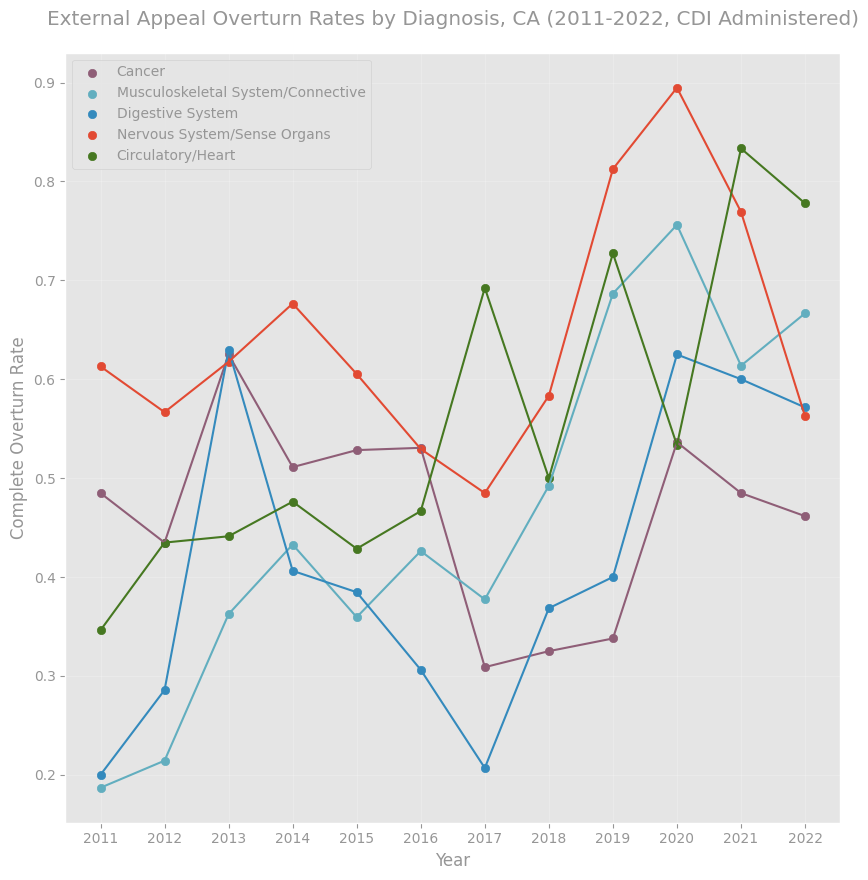

In [91]:
# Plot diagnosis decision rates over time
diagnosis_decision_data = get_overturn_rates_by_category(
    df, cat_col="Diagnosis", by_year=True
)
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Year"].unique())
if not NO_PLOT_TITLES:
    ax.set_title(
        "External Appeal Overturn Rates by Diagnosis, CA (2011-2022, CDI Administered)"
    )
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for diagnosis in diagnosis_val_counts[:5].keys():
    timeseries = []
    for year in x:
        if diagnosis_decision_data[diagnosis].get(year, None):
            timeseries.append(diagnosis_decision_data[diagnosis][year]["overturn_rate"])
        else:
            timeseries.append(None)
    ax.scatter(dates, timeseries, label=diagnosis)
    ax.plot(dates, timeseries)
ax.legend(loc="upper left")
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_diganosis.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

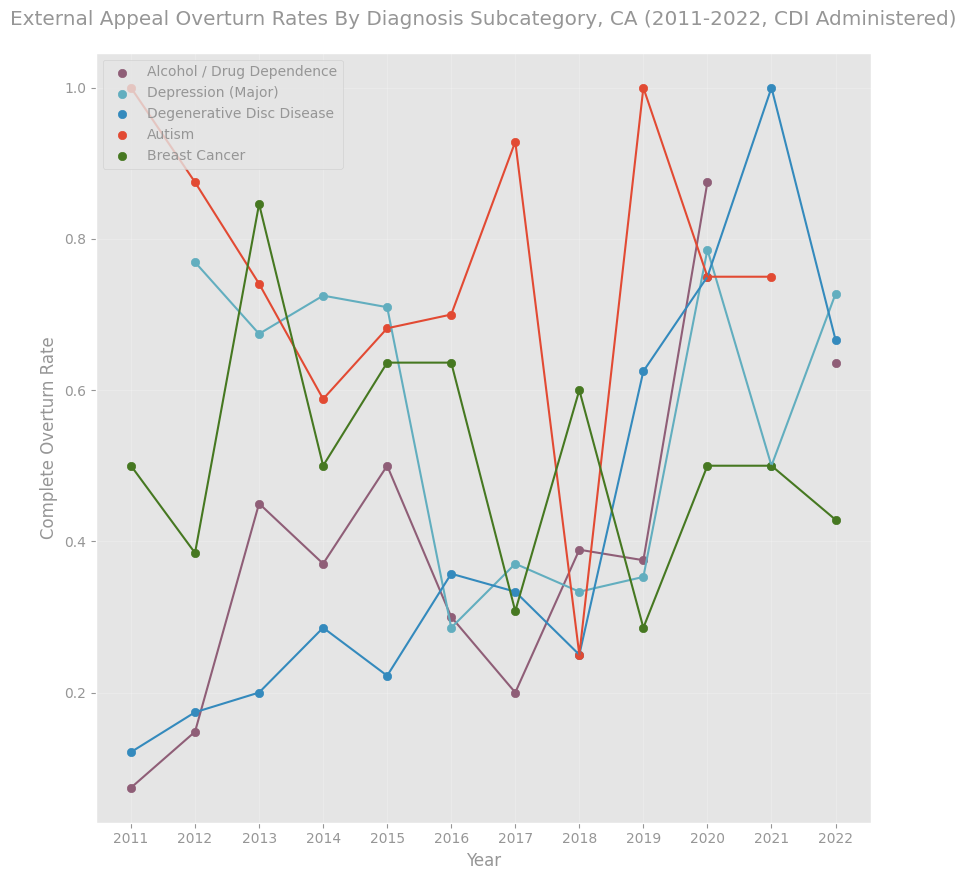

In [92]:
# Plot diagnosis decision rates over time
diagnosis_decision_data = get_overturn_rates_by_category(
    df, cat_col="Diagnosis Subcategory", by_year=True
)
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Year"].unique())
if not NO_PLOT_TITLES:
    ax.set_title(
        "External Appeal Overturn Rates By Diagnosis Subcategory, CA (2011-2022, CDI Administered)"
    )
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for diagnosis in subdiagnosis_val_counts[:5].keys():
    timeseries = []
    for year in x:
        if diagnosis_decision_data[diagnosis].get(year, None):
            timeseries.append(diagnosis_decision_data[diagnosis][year]["overturn_rate"])
        else:
            timeseries.append(None)
    ax.scatter(dates, timeseries, label=diagnosis)
    ax.plot(dates, timeseries)
ax.legend(loc="upper left")
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_diganosis_subcategory.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

#### Breakdowns By Demographic Information


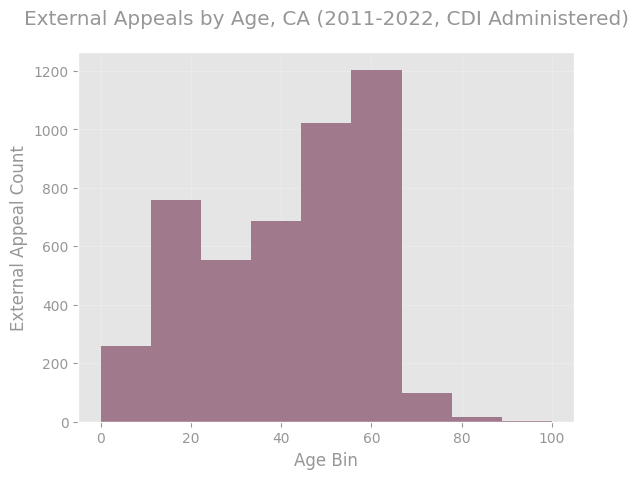

In [93]:
appeal_ages = df[df["Age"] != "-"]["Age"].astype(int)
title = "External Appeals by Age, CA (2011-2022, CDI Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Age Group"
bins = np.linspace(0, 100, 10)
plot_hist(
    appeal_ages,
    bins=bins,
    title=title if not NO_PLOT_TITLES else None,
    y_label="External Appeal Count",
    x_label="Age Bin",
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_age.png"),
)

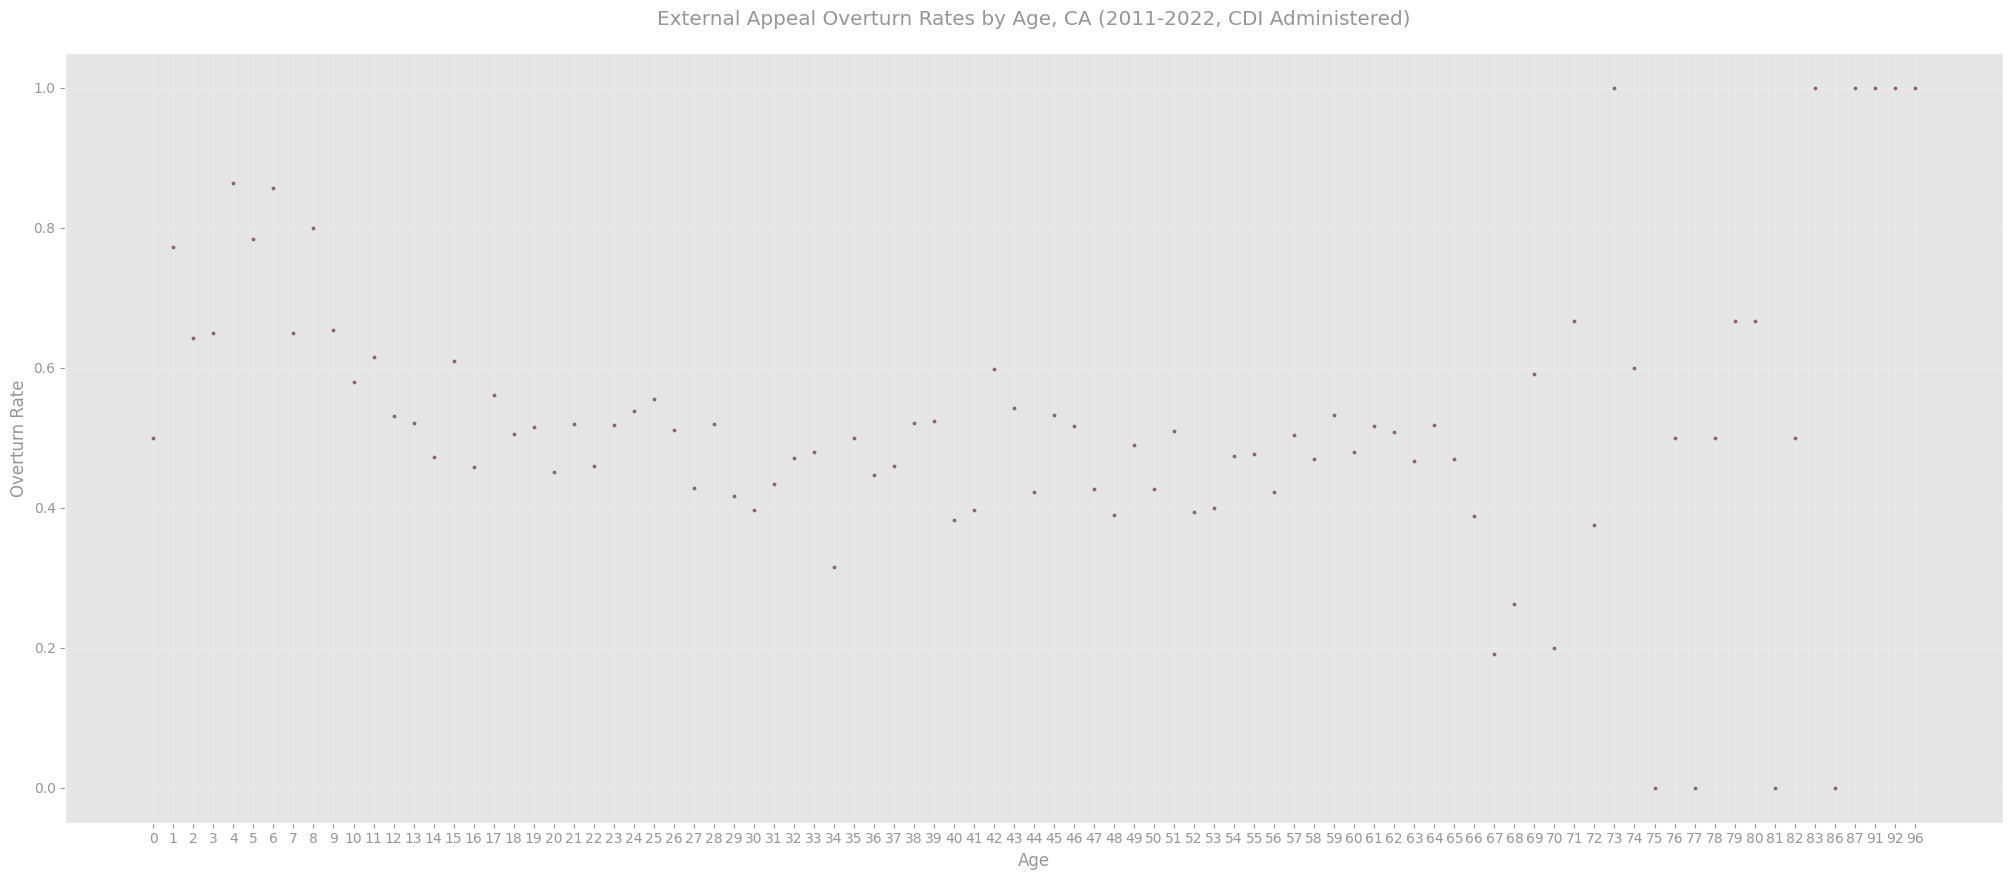

In [94]:
age_overturns = get_overturn_rates_by_categorical_col(df, "Age", exclude_cat_vals=["-"])
(cats, overturn_rates) = zip(*sorted(age_overturns, key=lambda x: int(x[0])))

title = "External Appeal Overturn Rates by Age, CA (2011-2022, CDI Administered)"
y_label = "Overturn Rate"
x_label = "Age"

fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(cats, overturn_rates, s=5)
ax.set_title(title)
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)
plt.show()

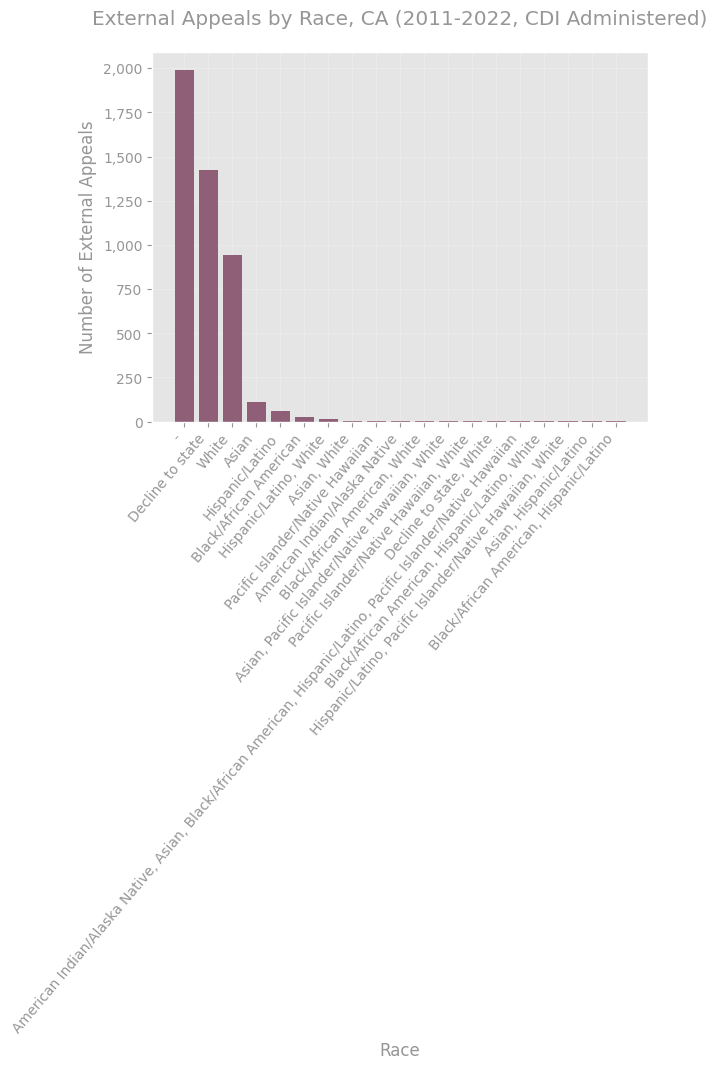

In [95]:
appeals_by_race = df["Race"].value_counts()
bar_names, bar_vals = list(appeals_by_race.index), appeals_by_race.values
title = "External Appeals by Race, CA (2011-2022, CDI Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Race"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_race.png"),
)

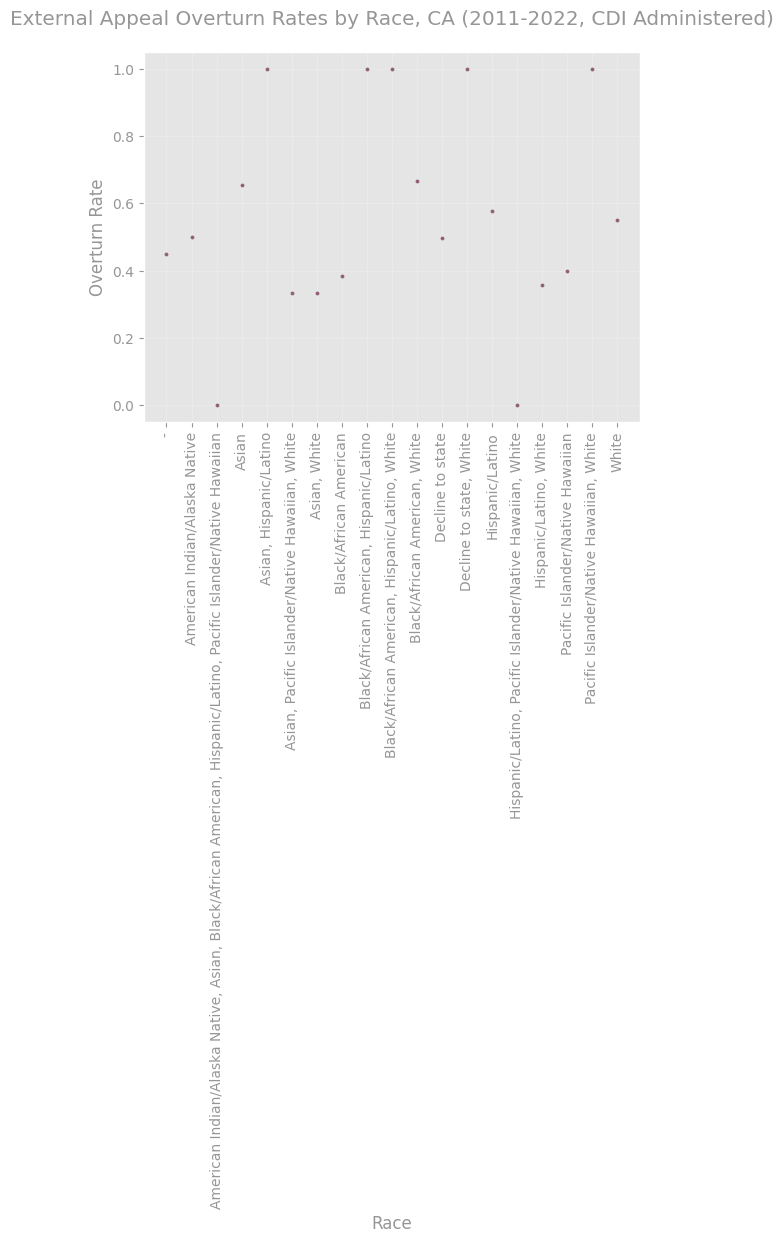

In [96]:
(cats, overturn_rates) = zip(*get_overturn_rates_by_categorical_col(df, "Race"))

title = "External Appeal Overturn Rates by Race, CA (2011-2022, CDI Administered)"
y_label = "Overturn Rate"
x_label = "Race"

fig, ax = plt.subplots()
ax.scatter(cats, overturn_rates, s=5)
ax.set_title(title)
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)
plt.xticks(rotation=90)
plt.show()

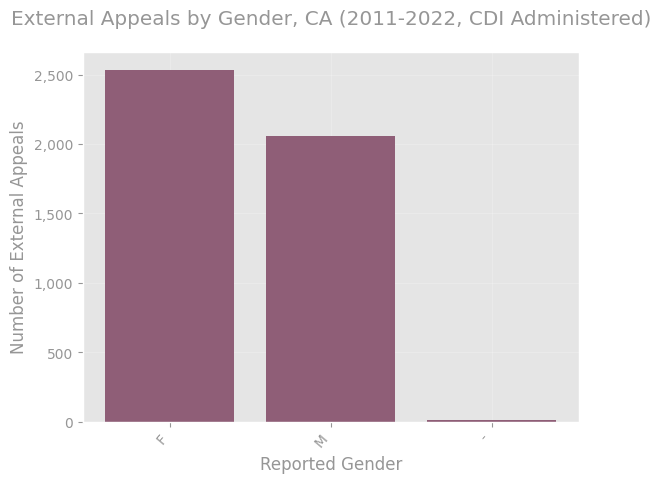

In [97]:
appeals_by_age = df["Gender"].value_counts()
bar_names, bar_vals = list(appeals_by_age.index), appeals_by_age.values
title = "External Appeals by Gender, CA (2011-2022, CDI Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Reported Gender"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_gender.png"),
)

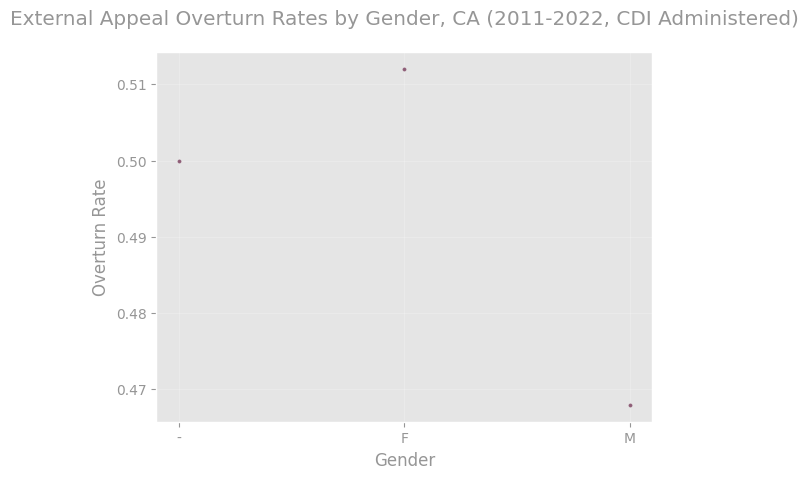

In [98]:
(cats, overturn_rates) = zip(*get_overturn_rates_by_categorical_col(df, "Gender"))

title = "External Appeal Overturn Rates by Gender, CA (2011-2022, CDI Administered)"
y_label = "Overturn Rate"
x_label = "Gender"

fig, ax = plt.subplots()
ax.scatter(cats, overturn_rates, s=5)
ax.set_title(title)
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)
plt.show()

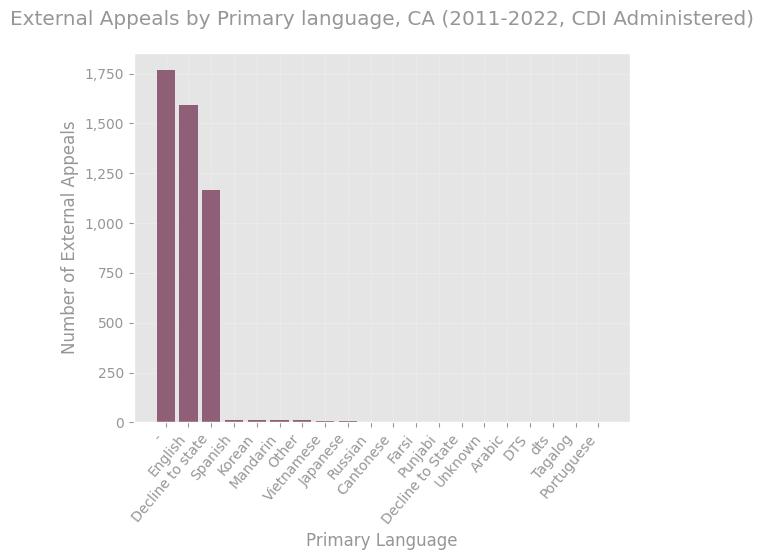

In [99]:
val_counts = df["Primary Language"].value_counts()
bar_names, bar_vals = list(val_counts.index), val_counts.values
title = "External Appeals by Primary language, CA (2011-2022, CDI Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Primary Language"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
)

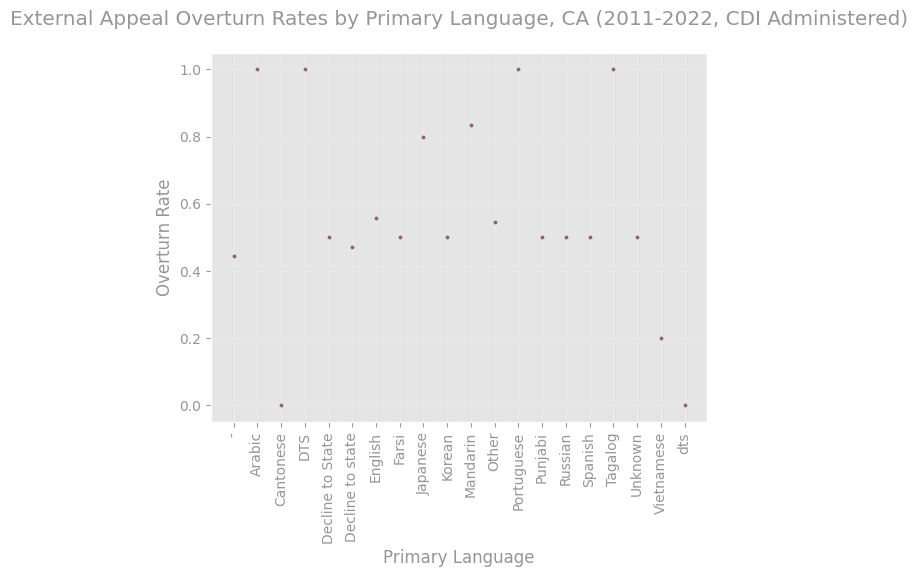

In [100]:
(cats, overturn_rates) = zip(
    *get_overturn_rates_by_categorical_col(df, "Primary Language")
)

title = "External Appeal Overturn Rates by Primary Language, CA (2011-2022, CDI Administered)"
y_label = "Overturn Rate"
x_label = "Primary Language"

fig, ax = plt.subplots()
ax.scatter(cats, overturn_rates, s=5)
plt.xticks(rotation=90)
ax.set_title(title)
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)
plt.show()

In [101]:
name = "Crohn's Disease"
pattern = r"\b(?:crohn's)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in [
            "Diagnosis",
            "Diagnosis Subcategory",
            "Treatment",
            "Treatment Subcategory",
        ]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
overturn_rate = get_overturn_rate(sub_df)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Crohn's Disease: 42.65% overturn rate among 68 external appeals.

Data sample:


Reference Number  Year           IMR Type  Priority         Diagnosis   
311         11-2151   2011       Experimental  Standard  Digestive System  \
345         11-2181   2011  Medical Necessity  Standard  Digestive System   
394         12-2707   2012  Medical Necessity  Standard  Digestive System   
914         13-3151   2013  Medical Necessity  Standard  Digestive System   
989         13-3334   2013       Experimental  Standard  Digestive System   

    Diagnosis Subcategory                                  Treatment   
311       Crohn's Disease                Pharmacy/Prescription Drugs  \
345       Crohn's Disease               Injection / Infusion Therapy   
394       Crohn's Disease               Injection / Infusion Therapy   
914       Crohn's Disease               Injection / Infusion Therapy   
989       Crohn's Disease  Diagnostic Imaging, Screening and Testing   

                         Treatment Subcategory                    Outcome Age   
311                         Prescription Drugs      Insurer Denial Upheld  33  \
345                      Injections/ Infusions      Insurer Denial Upheld  53   
394                      Injections/ Infusions      Insurer Denial Upheld  23   
914  IVIG Therapy - Intravenous Immunoglobulin  Insurer Denial Overturned  41   
989                           Laboratory tests  Insurer Denial Overturned  21   

    Gender Statutory Criteria Primary Language Race Imro Review Period   
311      F                  -                -    -               days  \
345      M                  -                -    -               days   
394      M                  -                -    -               days   
914      F                  -                -    -               days   
989      F                  -                -    -               days   

    Determination Period  
311                 days  
345                 days  
394                 days  
914                 days  
989                 days

In [102]:
name = "Ulcerative Colitis"
pattern = r"\b(?:uc|ulcerative colitis)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in [
            "Diagnosis",
            "Diagnosis Subcategory",
            "Treatment",
            "Treatment Subcategory",
        ]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
overturn_rate = get_overturn_rate(sub_df)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Ulcerative Colitis: 48.72% overturn rate among 39 external appeals.

Data sample:


Reference Number  Year           IMR Type  Priority         Diagnosis   
97           11-2302   2011       Experimental  Standard  Digestive System  \
196          11-2194   2011       Experimental  Standard  Digestive System   
359          11-2125   2011  Medical Necessity  Standard  Digestive System   
991          13-3333   2013       Experimental  Standard  Digestive System   
1310         13-3007   2013  Medical Necessity  Standard  Digestive System   

     Diagnosis Subcategory                                      Treatment   
97      Ulcerative Colitis  Electrical/ Thermal/ Radiofreq. Interventions  \
196     Ulcerative Colitis      Diagnostic Imaging, Screening and Testing   
359     Ulcerative Colitis      Diagnostic Imaging, Screening and Testing   
991     Ulcerative Colitis      Diagnostic Imaging, Screening and Testing   
1310    Ulcerative Colitis                   Injection / Infusion Therapy   

                                  Treatment Subcategory   
97                            Investigational Treatment  \
196               Immunofluorescent Study / Immunoassay   
359                                             CT Scan   
991   Monitoring Tests/Assays (Anser IFX/ADA,  ANA, ...   
1310            Prescription Drug/Medication Management   

                        Outcome Age Gender Statutory Criteria   
97    Insurer Denial Overturned  28      M                  -  \
196       Insurer Denial Upheld  20      F                  -   
359       Insurer Denial Upheld  47      M                  -   
991   Insurer Denial Overturned  49      F                  -   
1310  Insurer Denial Overturned  33      F                  -   

     Primary Language Race Imro Review Period Determination Period  
97                  -    -               days                 days  
196                 -    -               days                 days  
359                 -    -               days                 days  
991                 -    -               days                 days  
1310                -    -               days                 days

In [103]:
name = "Gender Identity"
pattern = r"\b(?:gender|affirming|transgender|dysphoria|sex change)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in [
            "Diagnosis",
            "Diagnosis Subcategory",
            "Treatment",
            "Treatment Subcategory",
        ]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
overturn_rate = get_overturn_rate(sub_df)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Gender Identity: 87.50% overturn rate among 32 external appeals.

Data sample:


Reference Number  Year           IMR Type  Priority   
2446         16-4601   2016  Medical Necessity  Standard  \
2741        17-6041    2017       Experimental  Standard   
2855        17-6126    2017  Medical Necessity  Standard   
3200        18-6459    2018  Medical Necessity  Standard   
3209        18-6450    2018  Medical Necessity  Standard   

                          Diagnosis          Diagnosis Subcategory   
2446  Sexual/Gender Identity Issues  Sexual/Gender identity Issues  \
2741  Sexual/Gender Identity Issues  Sexual/Gender Identity Issues   
2855  Sexual/Gender Identity Issues  Sexual/Gender Identity Issues   
3200  Sexual/Gender Identity Issues  Sexual/Gender Identity Issues   
3209  Sexual/Gender Identity Issues  Sexual/Gender Identity Issues   

                           Treatment Treatment Subcategory   
2446  Reconstructive/Plastic Surgery    Cosmetic Treatment  \
2741     Pharmacy/Prescription Drugs              Hormones   
2855  Reconstructive/Plastic Surgery   Breast Augmentation   
3200                 General Surgery        Breast Surgery   
3209  Reconstructive/Plastic Surgery        Breast Surgery   

                        Outcome Age Gender   
2446  Insurer Denial Overturned  43      F  \
2741  Insurer Denial Overturned  10      M   
2855  Insurer Denial Overturned  24      F   
3200      Insurer Denial Upheld  16      M   
3209  Insurer Denial Overturned  15      M   

                                     Statutory Criteria  Primary Language   
2446  Peer-reviewed scientific and medical evidence ...  Decline to state  \
2741  Peer-reviewed scientific and medical evidence ...           English   
2855  Peer-reviewed scientific and medical evidence ...  Decline to state   
3200  Expert Opinion\nNationally recognized professi...           English   
3209  Peer-reviewed scientific and medical evidence ...           English   

                  Race Imro Review Period Determination Period  
2446  Decline to state            28 days             133 days  
2741             White            29 days              79 days  
2855  Decline to state            23 days              69 days  
3200             White            50 days              67 days  
3209             White            34 days              44 days

In [104]:
name = "HIV/AIDS"
pattern = r"\b(?:HIV|AIDS)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in [
            "Diagnosis",
            "Diagnosis Subcategory",
            "Treatment",
            "Treatment Subcategory",
        ]
    ]
)
sub_df = df.loc[mask.any(axis=1)]

overturn_rate = get_overturn_rate(sub_df)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

HIV/AIDS: 71.43% overturn rate among 7 external appeals.

Data sample:


Reference Number  Year           IMR Type   Priority   
202          11-2071   2011  Medical Necessity   Standard  \
755          12-2576   2012  Medical Necessity   Standard   
974          13-3140   2013  Medical Necessity  Expedited   
1693         14-3546   2014       Experimental   Standard   
2635         16-4415   2016       Experimental   Standard   

                Diagnosis Diagnosis Subcategory   
202   Infectious Diseases      Retrovirus - HIV  \
755   Infectious Diseases      Retrovirus - HIV   
974   Infectious Diseases      Retrovirus - HIV   
1693  Infectious Diseases      Retrovirus - HIV   
2635  Infectious Diseases      Retrovirus - HIV   

                                      Treatment   Treatment Subcategory   
202                 Pharmacy/Prescription Drugs  AIDS Wasting Treatment  \
755                 Pharmacy/Prescription Drugs  Growth Hormone Therapy   
974                 Pharmacy/Prescription Drugs      Prescription Drugs   
1693             Reconstructive/Plastic Surgery       Implant Procedure   
2635  Diagnostic Imaging, Screening and Testing         Genetic Testing   

                        Outcome Age Gender   
202   Insurer Denial Overturned  46      M  \
755   Insurer Denial Overturned  27      M   
974       Insurer Denial Upheld  27      M   
1693  Insurer Denial Overturned  62      M   
2635  Insurer Denial Overturned  64      M   

                                     Statutory Criteria  Primary Language   
202                                                   -                 -  \
755                                                   -                 -   
974                                                   -                 -   
1693                                                  -                 -   
2635  Peer-reviewed scientific and medical evidence ...  Decline to state   

                  Race Imro Review Period Determination Period  
202                  -               days                 days  
755                  -               days                 days  
974                  -               days                 days  
1693                 -               days                 days  
2635  Decline to state            31 days             114 days

In [105]:
# Convert review period to integral values and handle " days"
df['Imro Review Period'] = pd.to_numeric(df['Imro Review Period'].str.replace(' days', '', regex=False), errors='coerce')

In [113]:
# Add binned age to json export
# Define the bins and labels for age groups
bins = [-5, -1, 10, 20, 30, 40, 50, 64, 100]  # Adjust the last bin edge to cover values up to 99
labels = ['-', '0 to 10', '11 to 20', '21 to 30', '31 to 40', '41 to 50', '51 to 64', '65+']

# Convert the "Age" column to age groups
df['binned_age'] = pd.cut(df['Age'].replace('-', '-2').astype(int), bins=bins, labels=labels, right=False)


In [115]:
# Export json data for visualization
export_df = df[["Year", "Priority", "Diagnosis", "Diagnosis Subcategory", "Treatment", "Treatment Subcategory", "Outcome", "Imro Review Period", "Race", "Gender", "Age", "binned_age"]]
export_df.to_json(path_or_buf=os.path.join(OUTPUT_DATA_DIR, "cdi.json"), orient="records")

### DMHC Appeals


In [41]:
OUTPUT_IMAGE_DIR = "./images/ca_dmhc_external_appeals"
OUTPUT_DATA_DIR = "./output_data/ca_dmhc_external_appeals"  # Set to None if you don't want to save non-required data for external use
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

In [42]:
url = "https://data.chhs.ca.gov/dataset/b79b3447-4c10-4ae6-84e2-1076f83bb24e/resource/3340c5d7-4054-4d03-90e0-5f44290ed095/download/independent-medical-review-imr-determinations-trends.csv"
dmhc_imr_data_path = os.path.join(INPUT_DATA_DIR, "ca_dmhc.csv")
download_file_from_url(url, dmhc_imr_data_path)

Target file ./input_data/ca_dmhc.csv already exists.


In [43]:
df = pd.read_csv(dmhc_imr_data_path, encoding="latin1").sort_values(
    by="ReportYear", ignore_index=True
)

In [44]:
print(f"This dataset contains a total of {len(df)} IMRs administered by DMHC.")
for year, count in df["ReportYear"].value_counts(sort=False).items():
    print(f"\t{count} IMRs from {year}")

# # Remove 2023 records, since claims are still being adjudicated, there are pending internal appeals, etc.
# Yields view of statistics that is inconsistent with methodology for complete years
df = df[df["ReportYear"] != 2023]

This dataset contains a total of 34615 IMRs administered by DMHC.
	28 IMRs from 2001
	689 IMRs from 2002
	731 IMRs from 2003
	787 IMRs from 2004
	959 IMRs from 2005
	1080 IMRs from 2006
	1342 IMRs from 2007
	1520 IMRs from 2008
	1429 IMRs from 2009
	1452 IMRs from 2010
	1435 IMRs from 2011
	1200 IMRs from 2012
	1195 IMRs from 2013
	1432 IMRs from 2014
	2076 IMRs from 2015
	3053 IMRs from 2016
	2953 IMRs from 2017
	2683 IMRs from 2018
	2331 IMRs from 2019
	2197 IMRs from 2020
	2132 IMRs from 2021
	1769 IMRs from 2022
	142 IMRs from 2023


In [45]:
appeal_decision_counts = df["Determination"].value_counts()
print_appeal_results(appeal_decision_counts)

['Upheld Decision of Health Plan', 'Overturned Decision of Health Plan']
51% of all original determinations in external appeals were upheld
49% of all original determinations in external appeals were overturned.


In [46]:
uphold_cat_name = "Upheld Decision of Health Plan"
overturn_cat_name = "Overturned Decision of Health Plan"
year_cat_name = "ReportYear"
denial_type_cat_name = "Type"
diagnosis_cat_name = "DiagnosisCategory"
diagnosis_subcat_name = "DiagnosisSubCategory"

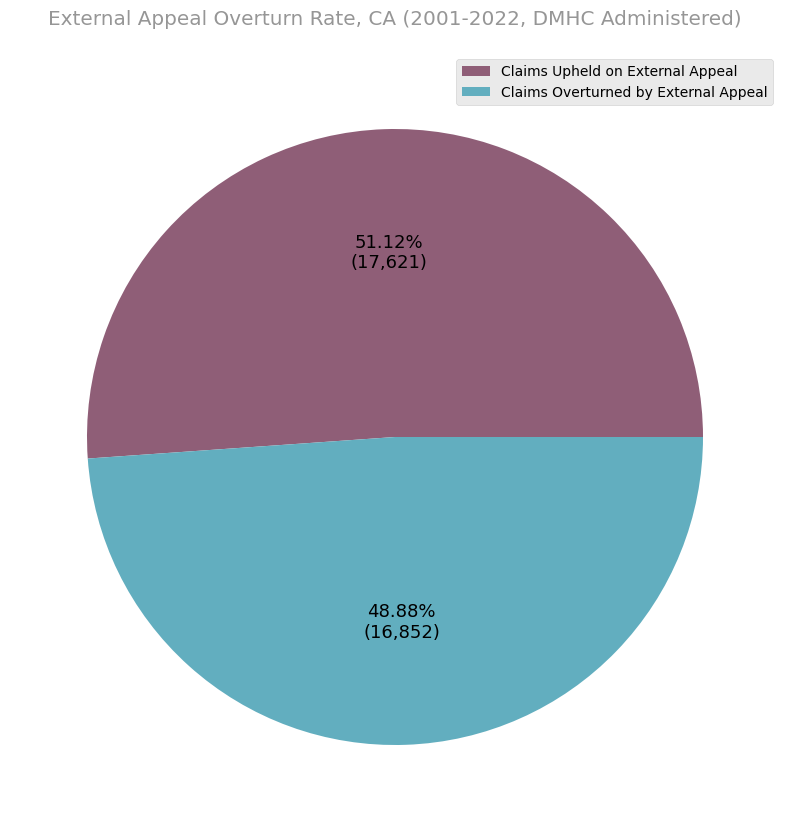

In [47]:
claims_externally_appealed = (
    appeal_decision_counts[uphold_cat_name] + appeal_decision_counts[overturn_cat_name]
)
claims_externally_overturned = appeal_decision_counts[overturn_cat_name]
external_appeals_upheld = claims_externally_appealed - claims_externally_overturned
plot_pie(
    slice_names=[
        "Claims Upheld on External Appeal",
        "Claims Overturned by External Appeal",
    ],
    slice_vals=[external_appeals_upheld, claims_externally_overturned],
    title="External Appeal Overturn Rate, CA (2001-2022, DMHC Administered)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_success_rates.png"),
    show=True,
)

/tmp/ipykernel_10581/1266561425.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates, rotation=45)


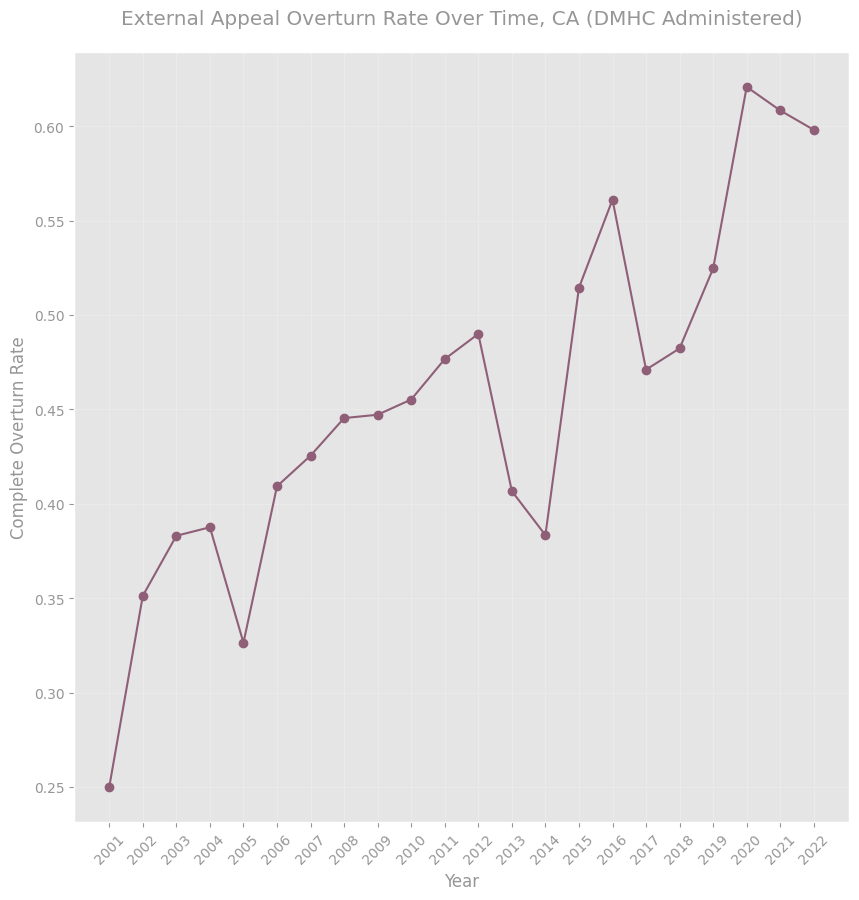

In [48]:
# Plot overall decision rates by year
decision_data = get_overturn_rates_by_category(
    df,
    year_cat_name,
    outcome_col="Determination",
    upheld_cat_name=uphold_cat_name,
    overturned_cat_name=overturn_cat_name,
)
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df[year_cat_name].unique())
if not NO_PLOT_TITLES:
    ax.set_title("External Appeal Overturn Rate Over Time, CA (DMHC Administered)")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
timeseries = []
for year in x:
    if decision_data.get(year, None):
        timeseries.append(decision_data[year]["overall"]["overturn_rate"])
    else:
        timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, timeseries, "o-")
ax.set_xticklabels(dates, rotation=45)
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

/tmp/ipykernel_10581/3212926777.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates, rotation=45)


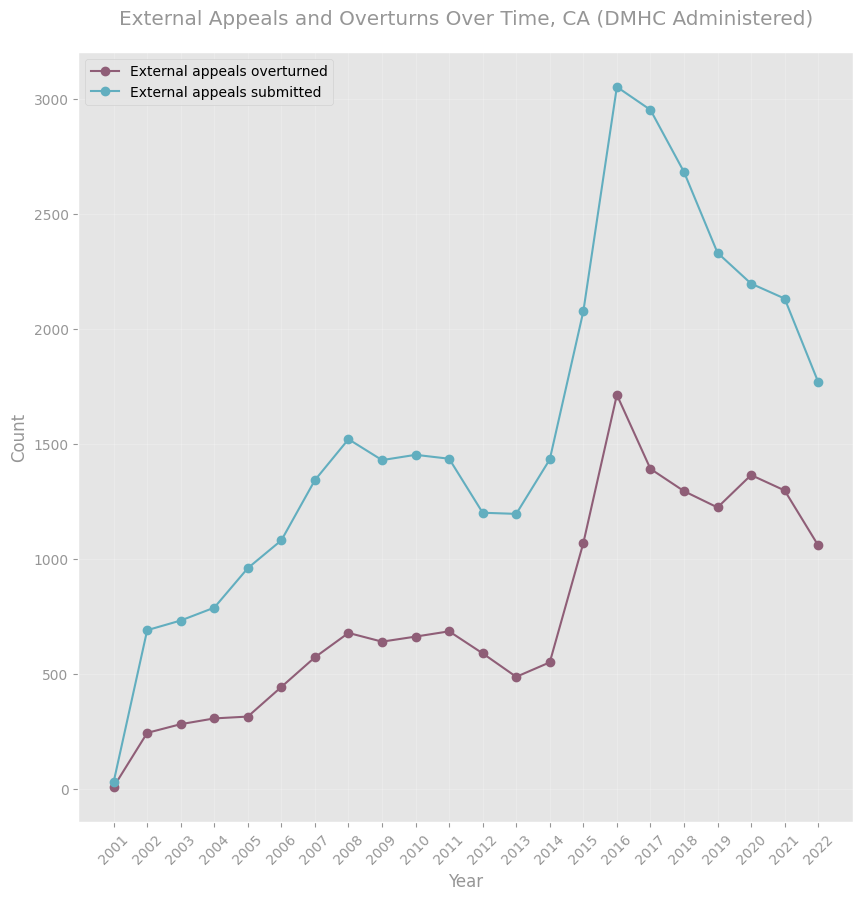

In [49]:
# Plot complete overturns and number of external appeals over same time period, to see what's affecting rate
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df[year_cat_name].unique())
if not NO_PLOT_TITLES:
    ax.set_title("External Appeals and Overturns Over Time, CA (DMHC Administered)")
ax.set_ylabel("Count")
ax.set_xlabel("Year")
appeals_timeseries = []
overturns_timeseries = []
for year in x:
    if decision_data.get(year, None):
        year_data = decision_data[year]["overall"]
        appeals_timeseries.append(
            year_data["overturned"] + year_data["withdrew"] + year_data["upheld"]
        )
        overturns_timeseries.append(year_data["overturned"])
    else:
        appeals_timeseries.append(None)
        overturns_timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, overturns_timeseries, "o-", label="External appeals overturned")
ax.plot(dates, appeals_timeseries, "o-", label="External appeals submitted")
ax.set_xticklabels(dates, rotation=45)
ax.legend(labelcolor="black", loc="upper left")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

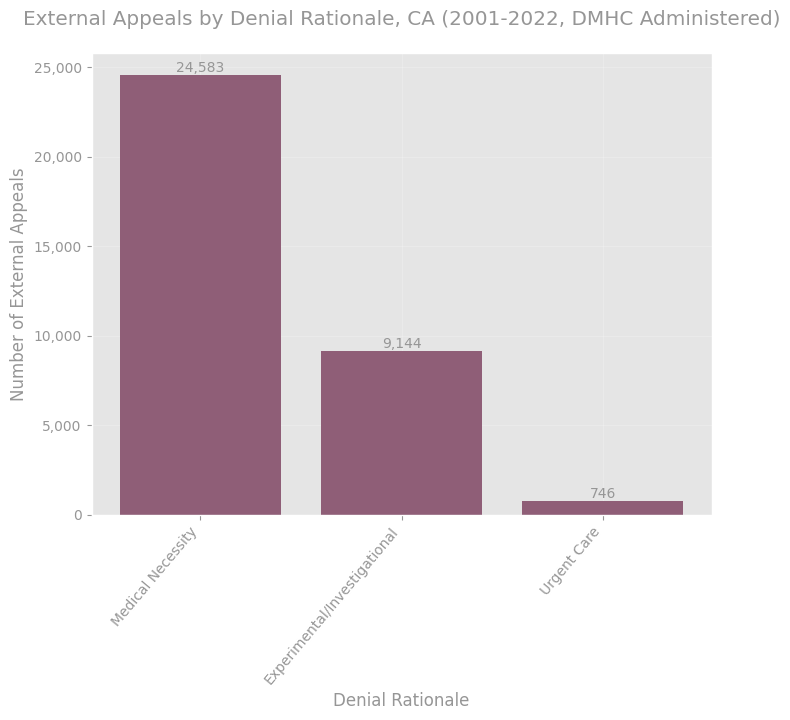

In [50]:
# Breakdown Appeals by Initial Denial Rationale
title = "External Appeals by Denial Rationale, CA (2001-2022, DMHC Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Denial Rationale"
denial_val_counts = df[denial_type_cat_name].value_counts()
bar_names, bar_vals = list(denial_val_counts.index), denial_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_denial_reason.png"),
    figsize=(8, 6),
)

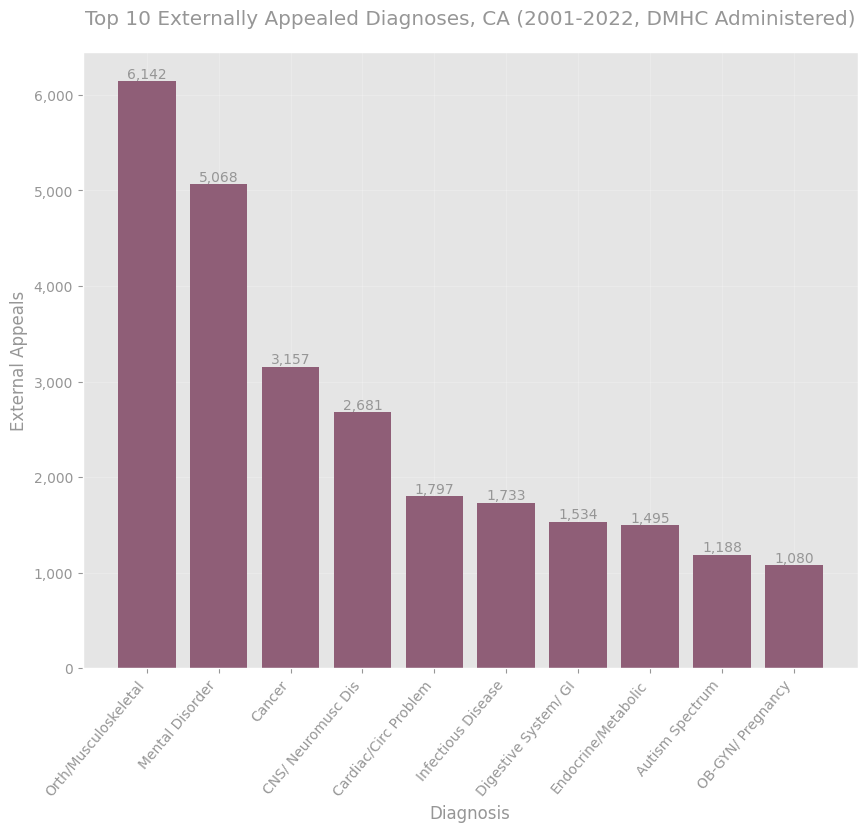

In [51]:
# Diagnosis breakdowns
n = 10
title = f"Top {n} Externally Appealed Diagnoses, CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = df[diagnosis_cat_name].value_counts()[:n]
bar_names, bar_vals = list(diagnosis_val_counts.index), diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnoses.png"),
    bar_label=True,
    figsize=(10, 8),
)

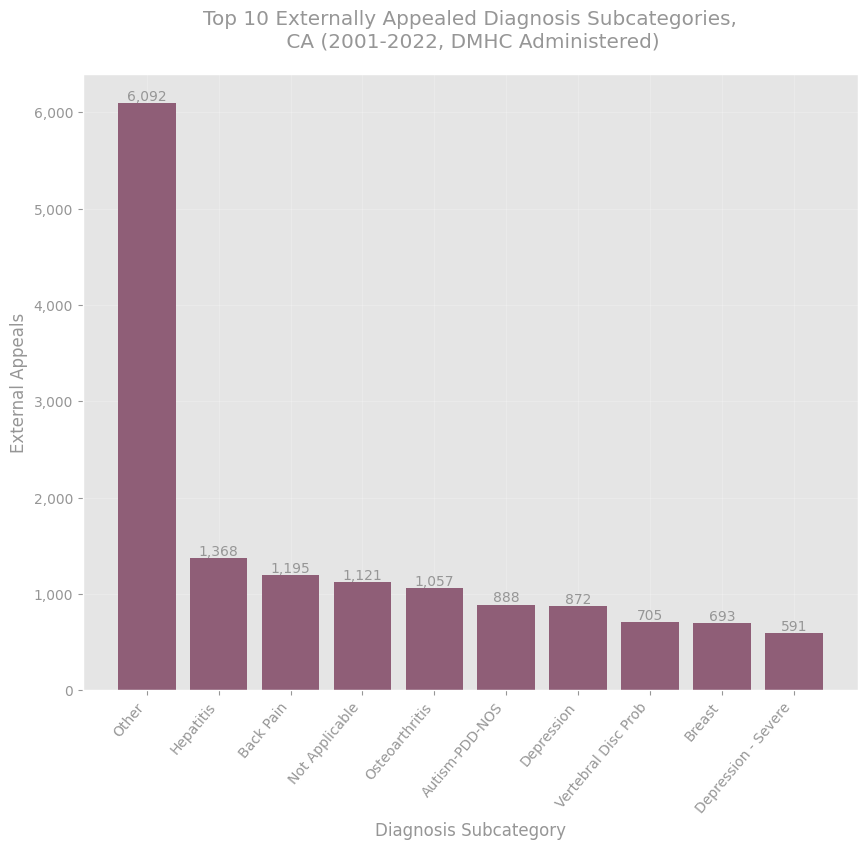

In [52]:
# Diagnosis breakdowns
n = 10
title = f"Top {n} Externally Appealed Diagnosis Subcategories,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis Subcategory"
subdiagnosis_val_counts = df[diagnosis_subcat_name].value_counts()[:n]
bar_names, bar_vals = (
    list(subdiagnosis_val_counts.index),
    subdiagnosis_val_counts.values,
)
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnosis_subcategories.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

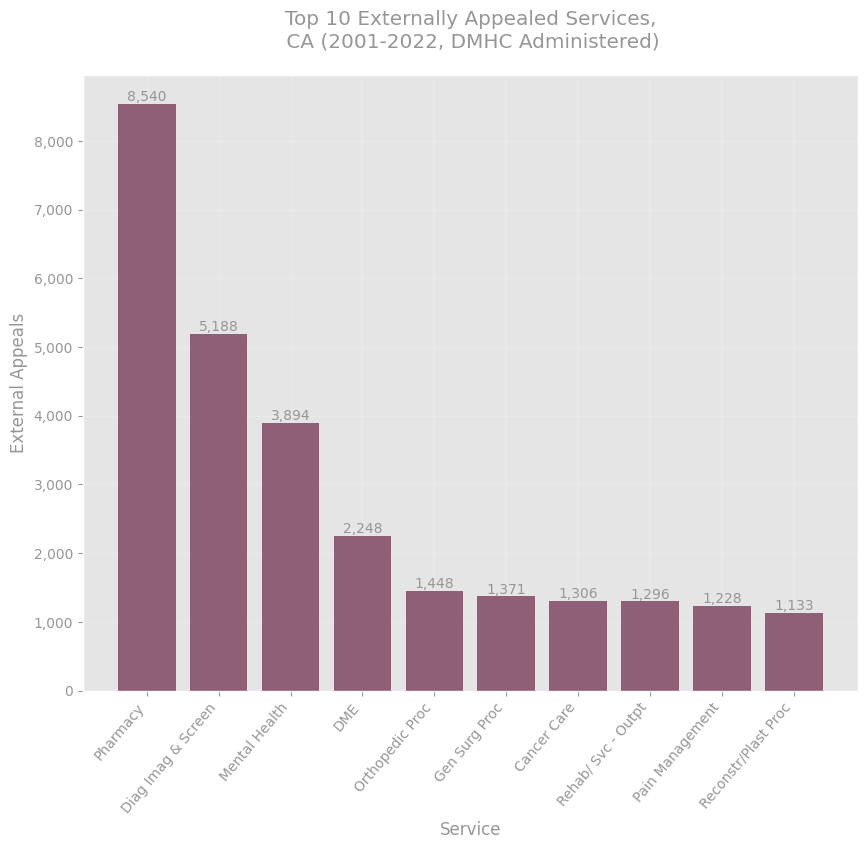

In [53]:
# Service
n = 10
title = f"Top {n} Externally Appealed Services,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Service"
treat_val_counts = df["TreatmentCategory"].value_counts()[:n]
bar_names, bar_vals = list(treat_val_counts.index), treat_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_treatments.png"),
    bar_label=True,
    figsize=(10, 8),
)

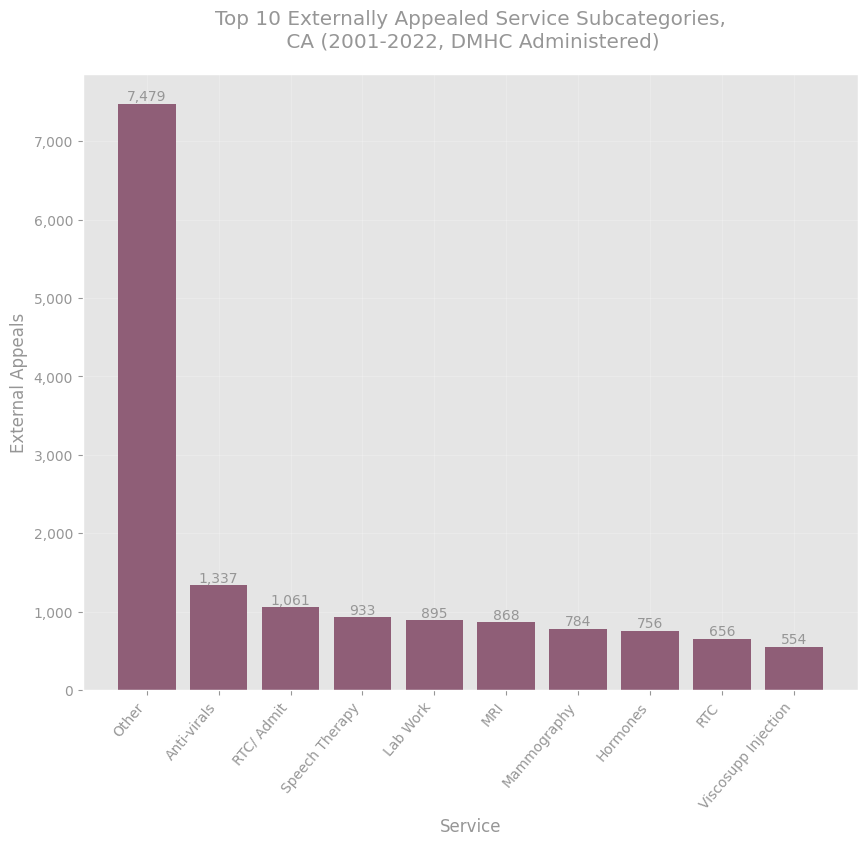

In [54]:
# Service subcat
n = 10
title = f"Top {n} Externally Appealed Service Subcategories,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Service"
treat_val_counts = df["TreatmentSubCategory"].value_counts()[:n]
bar_names, bar_vals = list(treat_val_counts.index), treat_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_treatments_subcats.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

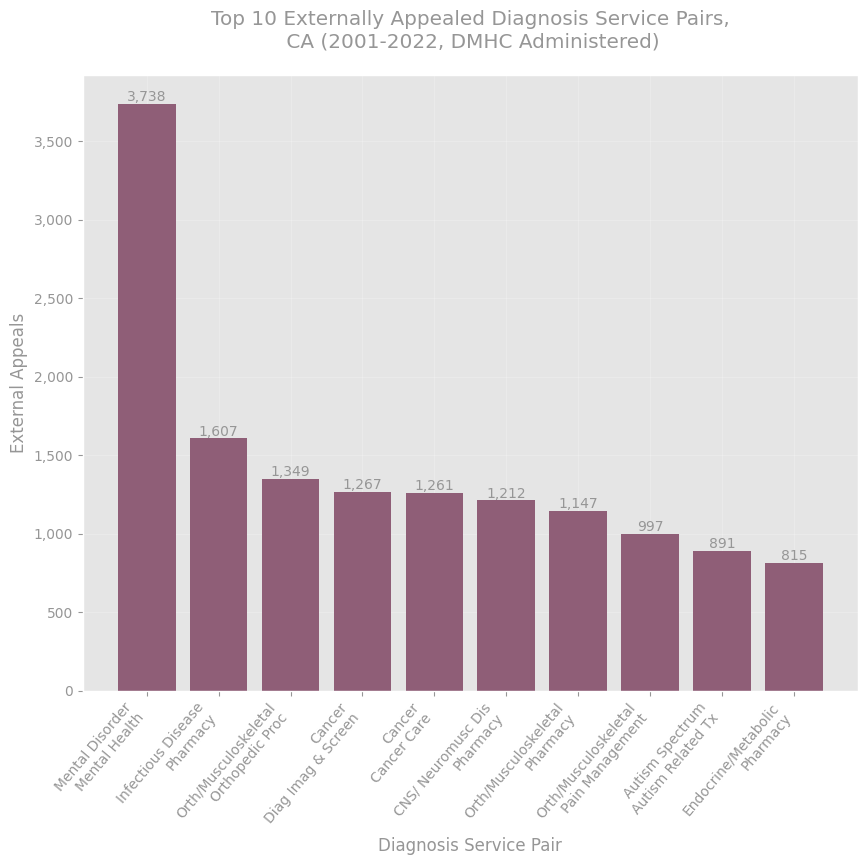

In [55]:
# Service/ Diagnosis Pairs
n = 10
title = f"Top {n} Externally Appealed Diagnosis Service Pairs,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis Service Pair"
diag_treat_pairs = (
    df.groupby(["DiagnosisCategory", "TreatmentCategory"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0] + "\n" + x[1]
    for x in zip(
        diag_treat_pairs["DiagnosisCategory"].values,
        diag_treat_pairs["TreatmentCategory"].values,
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_appealed_diag_services.png"),
    bar_label=True,
    figsize=(10, 8),
)

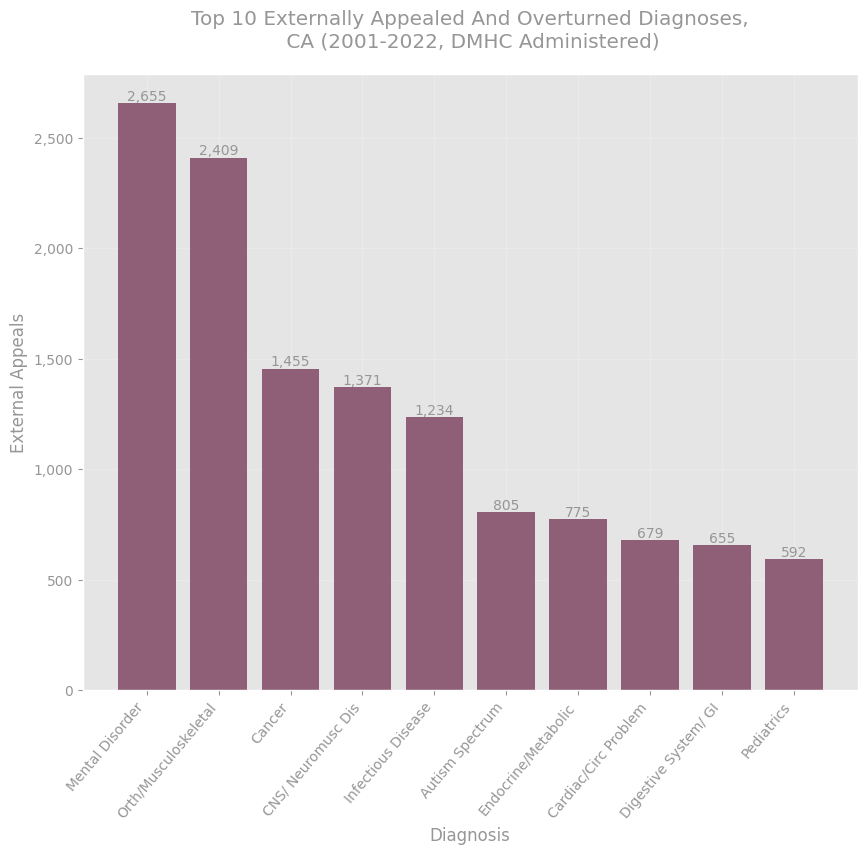

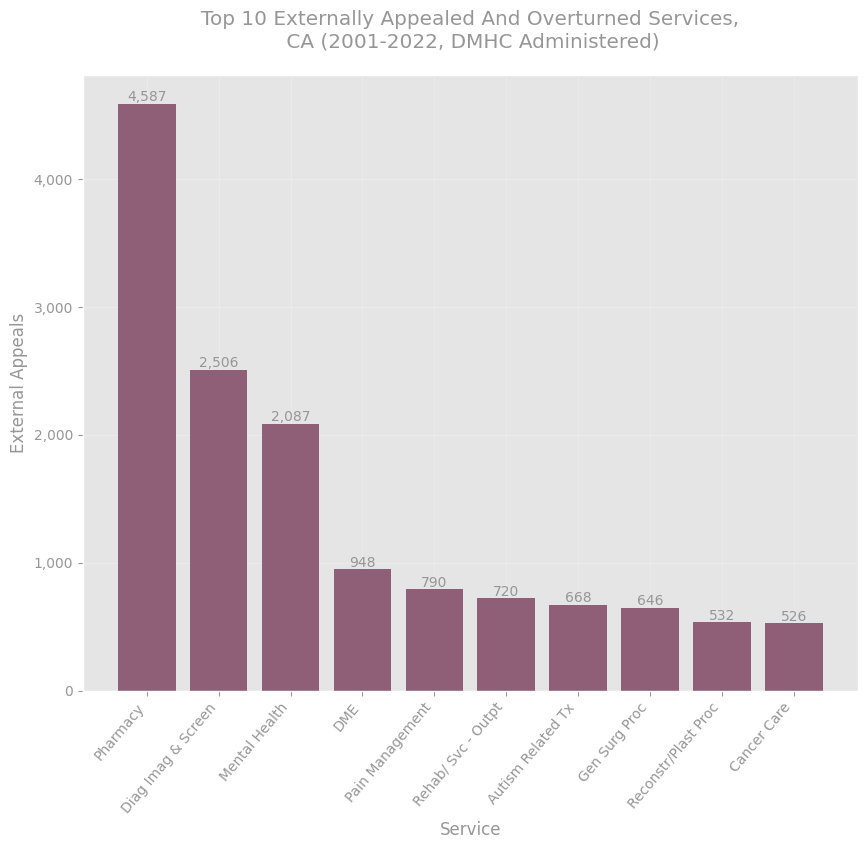

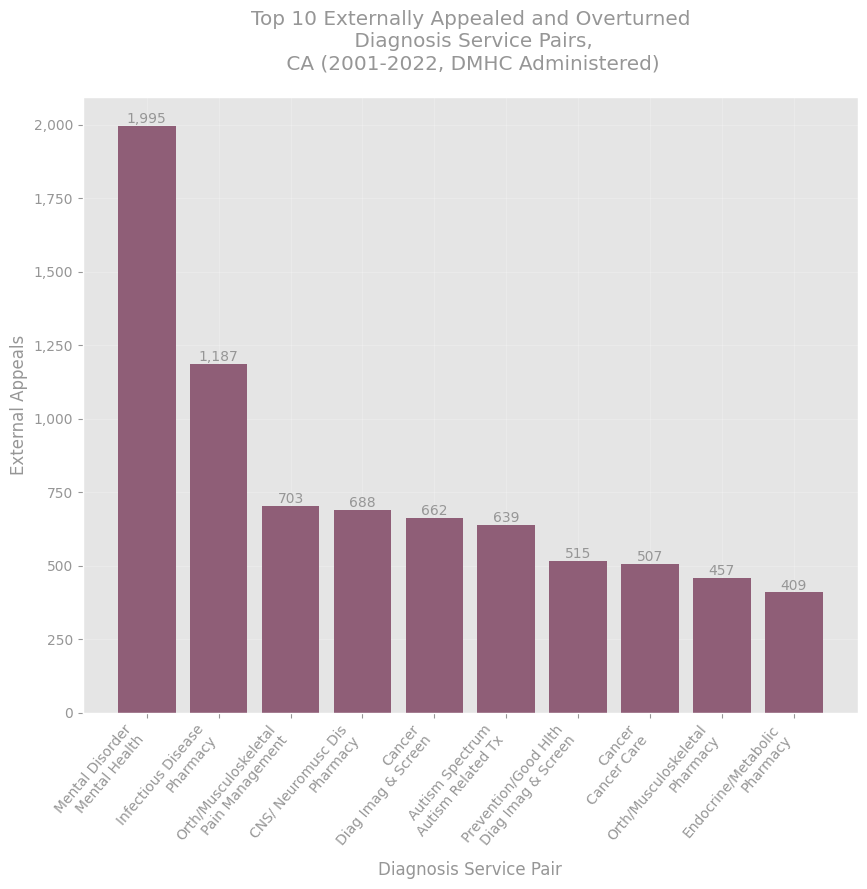

In [56]:
# Top Diagnoses, Services and Pairs for Overturned
overturns = df[df["Determination"] == "Overturned Decision of Health Plan"]

# Diagnosis breakdowns
n = 10
title = f"Top {n} Externally Appealed And Overturned Diagnoses,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = overturns["DiagnosisCategory"].value_counts()[:n]
bar_names, bar_vals = list(diagnosis_val_counts.index), diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_overturned_diagnoses.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

# Service
title = f"Top {n} Externally Appealed And Overturned Services,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Service"
treat_val_counts = overturns["TreatmentCategory"].value_counts()[:n]
bar_names, bar_vals = list(treat_val_counts.index), treat_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_overturned_treatments.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

# Service / Diagnosis Pairs
title = f"Top {n} Externally Appealed and Overturned\n Diagnosis Service Pairs,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis Service Pair"
diag_treat_pairs = (
    overturns.groupby(["DiagnosisCategory", "TreatmentCategory"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0] + "\n" + x[1]
    for x in zip(
        diag_treat_pairs["DiagnosisCategory"].values,
        diag_treat_pairs["TreatmentCategory"].values,
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_overturned_diag_services.png"),
    bar_label=True,
    figsize=(10, 8),
)

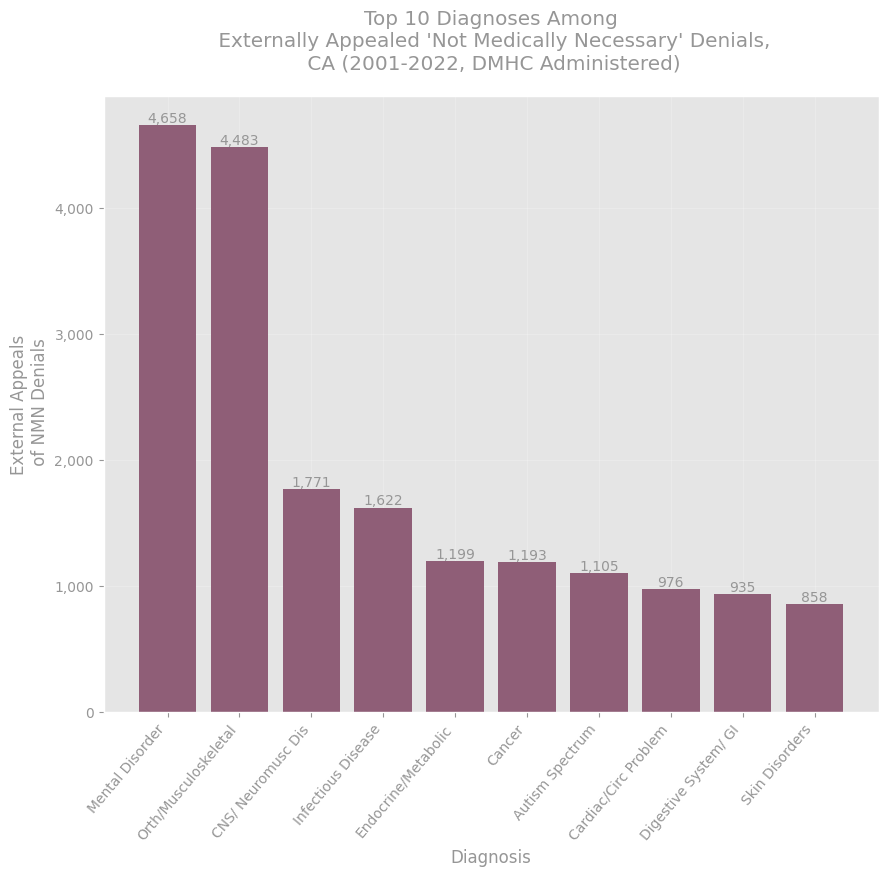

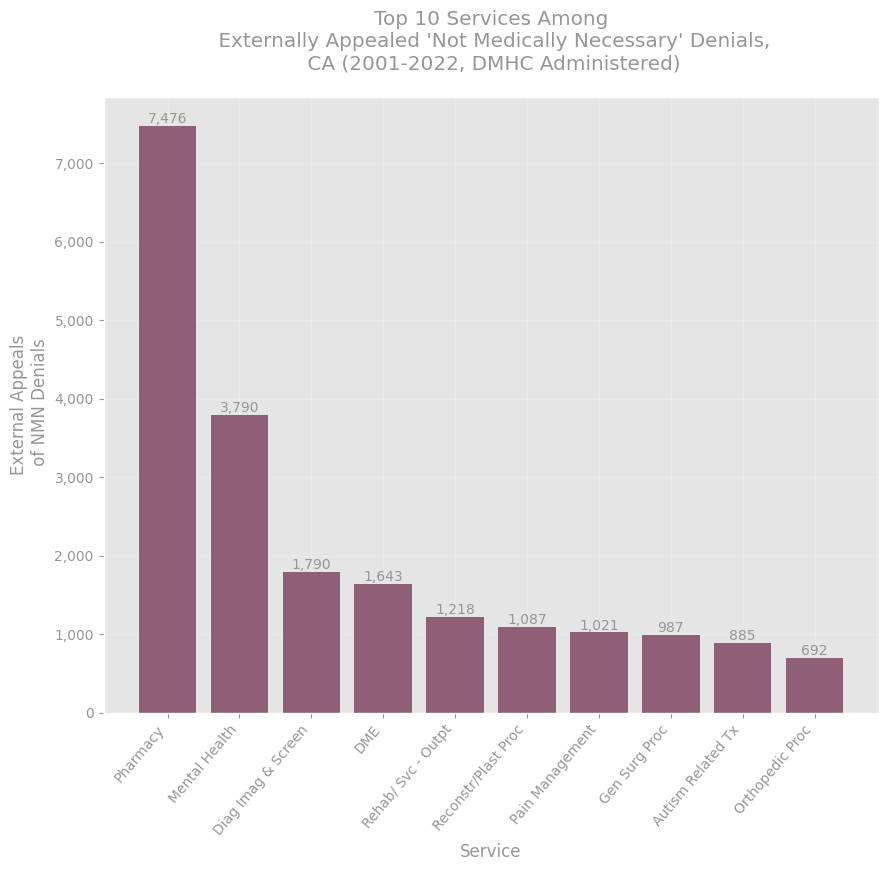

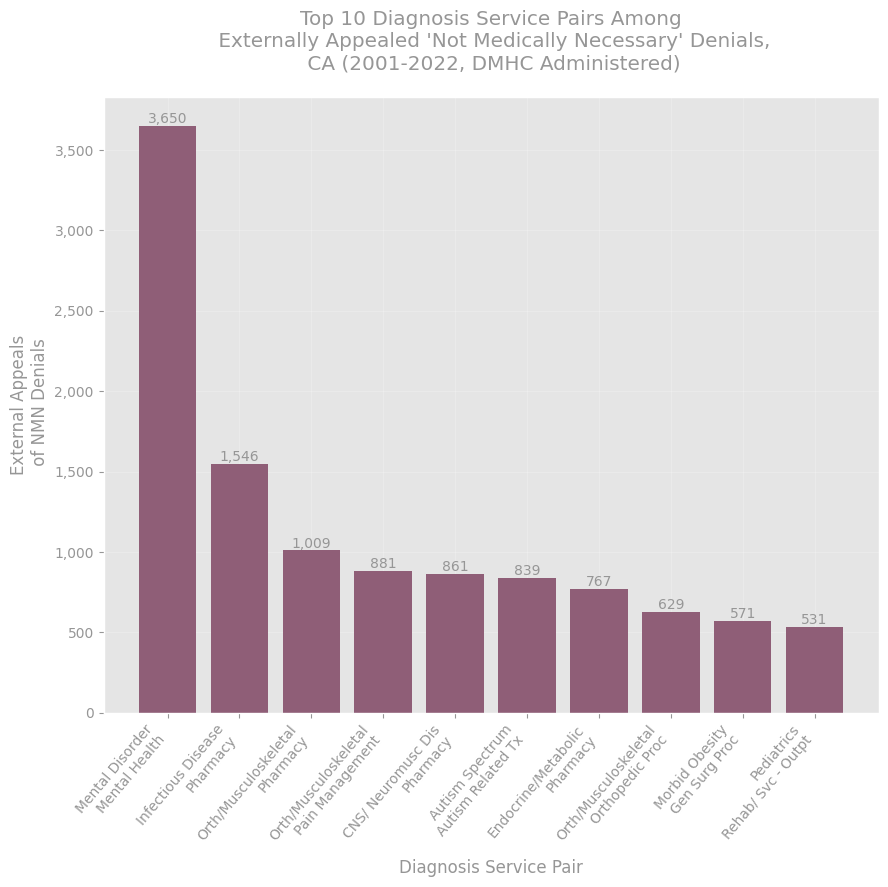

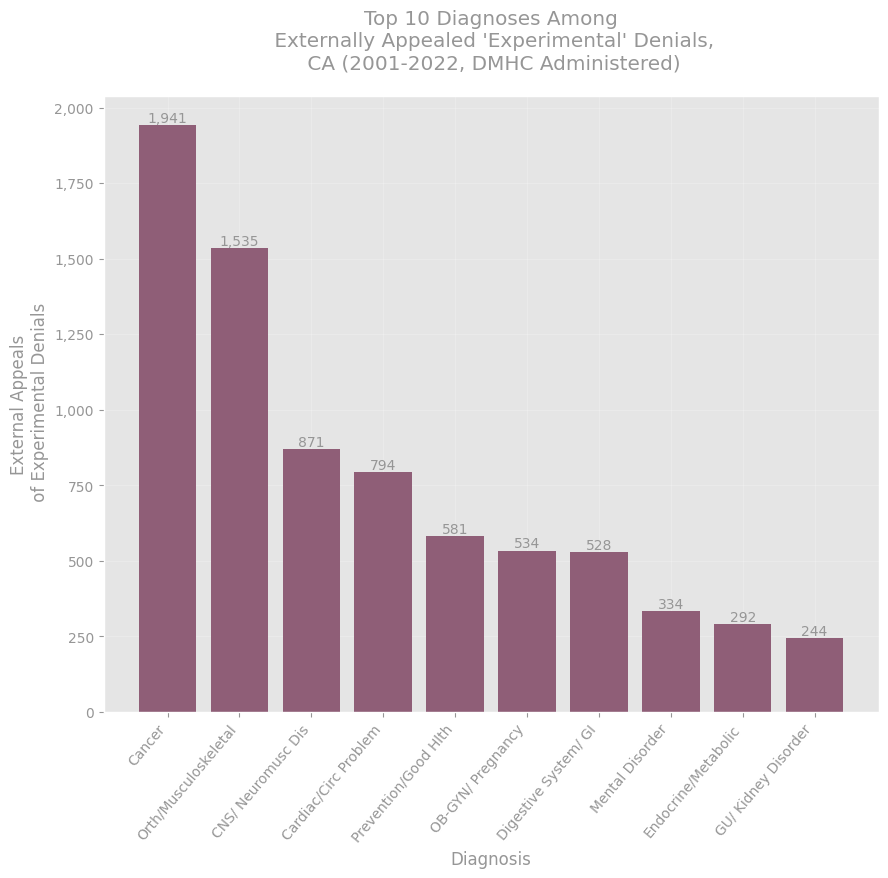

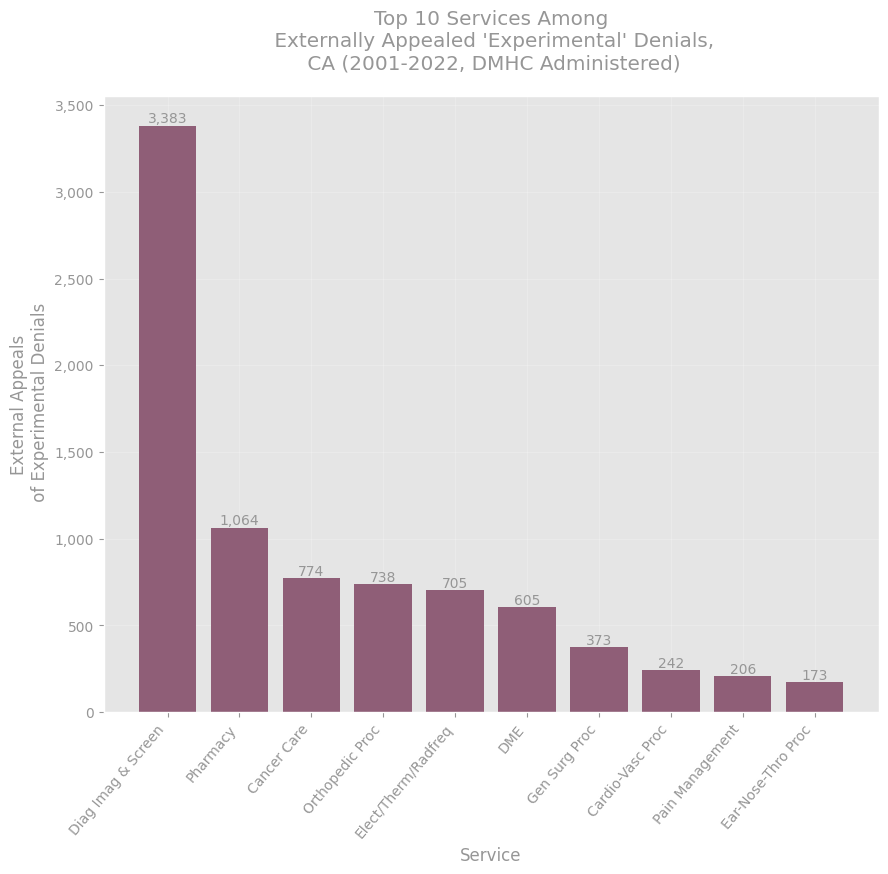

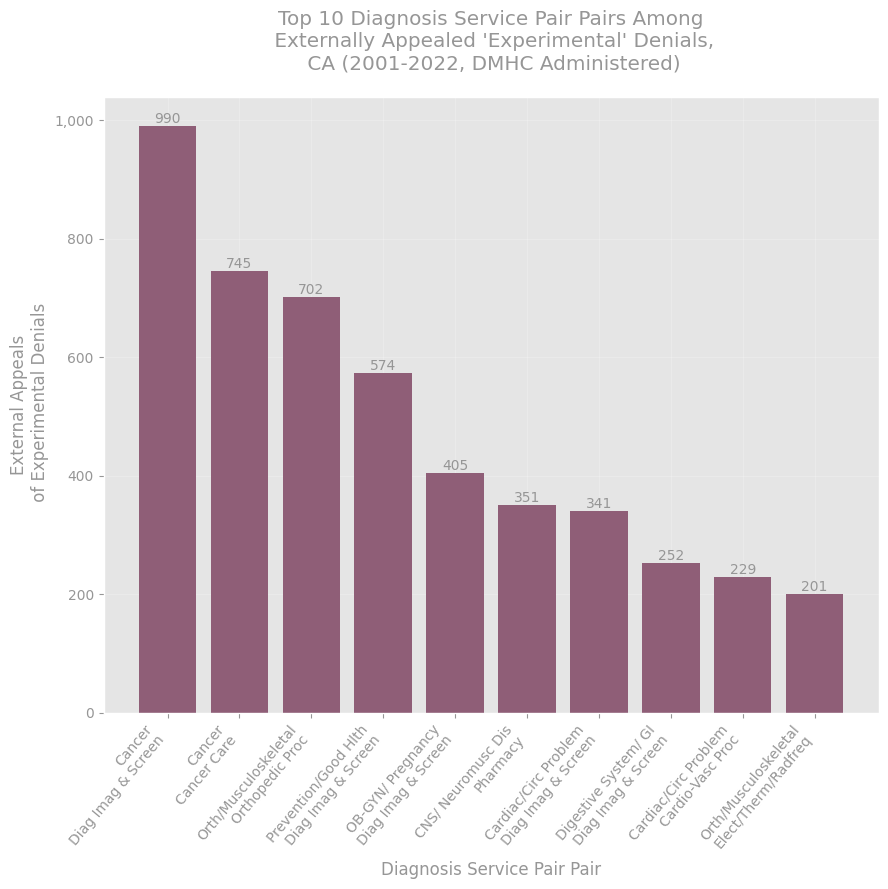

In [57]:
# Top Diagnoses, Services and Pairs for NMN/Experimental Appeals
nmn = df[df["Type"] == "Medical Necessity"]
experimental = df[df["Type"] == "Experimental/Investigational"]
n = 10

title = f"Top {n} Diagnoses Among\n Externally Appealed 'Not Medically Necessary' Denials,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals\n of NMN Denials"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = nmn["DiagnosisCategory"].value_counts()[:n]
bar_names, bar_vals = list(diagnosis_val_counts.index), diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_nmn_appeal_diagnoses.png"),
    figsize=(10, 8),
    bar_label=True,
)

title = f"Top {n} Services Among\n Externally Appealed 'Not Medically Necessary' Denials,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals\n of NMN Denials"
cat_axis_label = "Service"
service_val_counts = nmn["TreatmentCategory"].value_counts()[:n]
bar_names, bar_vals = list(service_val_counts.index), service_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_nmn_appeal_services.png"),
    figsize=(10, 8),
    bar_label=True,
)

title = f"Top {n} Diagnosis Service Pairs Among\n Externally Appealed 'Not Medically Necessary' Denials,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals\n of NMN Denials"
cat_axis_label = "Diagnosis Service Pair"
diag_treat_pairs = (
    nmn.groupby(["DiagnosisCategory", "TreatmentCategory"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0] + "\n" + x[1]
    for x in zip(
        diag_treat_pairs["DiagnosisCategory"].values,
        diag_treat_pairs["TreatmentCategory"].values,
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_nmn_appeal_diag_service.png"),
    figsize=(10, 8),
    bar_label=True,
)

# Diagnosis breakdowns among Experimental Denials
n = 10
title = f"Top {n} Diagnoses Among\n Externally Appealed 'Experimental' Denials,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals\n of Experimental Denials"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = experimental["DiagnosisCategory"].value_counts()[:n]
bar_names, bar_vals = list(diagnosis_val_counts.index), diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_experimental_appeal_diagnoses.png"),
    bar_label=True,
    figsize=(10, 8),
)

title = f"Top {n} Services Among\n Externally Appealed 'Experimental' Denials,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals\n of Experimental Denials"
cat_axis_label = "Service"
treat_val_counts = experimental["TreatmentCategory"].value_counts()[:n]
bar_names, bar_vals = list(treat_val_counts.index), treat_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_experimental_appeal_services.png"),
    bar_label=True,
    figsize=(10, 8),
)

title = f"Top {n} Diagnosis Service Pair Pairs Among\n Externally Appealed 'Experimental' Denials,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals\n of Experimental Denials"
cat_axis_label = "Diagnosis Service Pair Pair"
diag_treat_pairs = (
    experimental.groupby(["DiagnosisCategory", "TreatmentCategory"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0] + "\n" + x[1]
    for x in zip(
        diag_treat_pairs["DiagnosisCategory"].values,
        diag_treat_pairs["TreatmentCategory"].values,
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_experimental_appeal_diag_services.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

/tmp/ipykernel_10581/2246422036.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates, rotation=45)


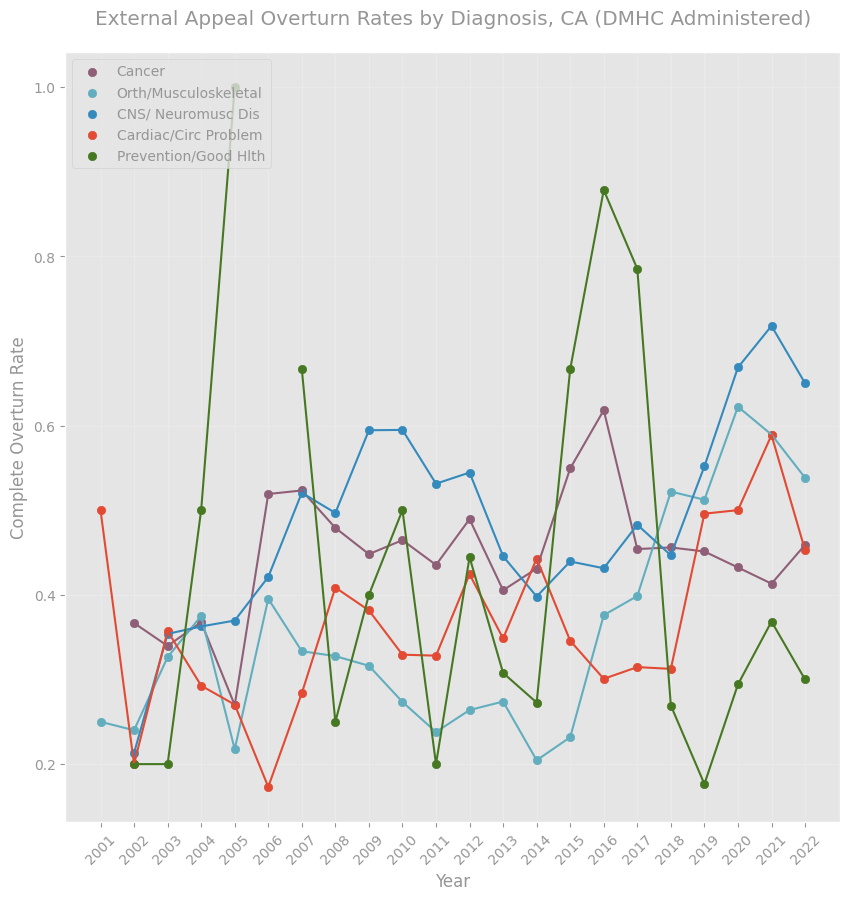

In [58]:
# Plot diagnosis decision rates over time
diagnosis_decision_data = get_overturn_rates_by_category(
    df,
    outcome_col="Determination",
    cat_col=diagnosis_cat_name,
    by_year=True,
    upheld_cat_name=uphold_cat_name,
    overturned_cat_name=overturn_cat_name,
    year_cat_name=year_cat_name,
)
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df[year_cat_name].unique())
if not NO_PLOT_TITLES:
    ax.set_title("External Appeal Overturn Rates by Diagnosis, CA (DMHC Administered)")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for diagnosis in diagnosis_val_counts[:5].keys():
    timeseries = []
    for year in x:
        if diagnosis_decision_data[diagnosis].get(year, None):
            timeseries.append(diagnosis_decision_data[diagnosis][year]["overturn_rate"])
        else:
            timeseries.append(None)
    ax.scatter(dates, timeseries, label=diagnosis)
    ax.plot(dates, timeseries)
ax.legend(loc="upper left")
ax.set_xticklabels(dates, rotation=45)
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_diganosis.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

#### Breakdowns By Demographic Information

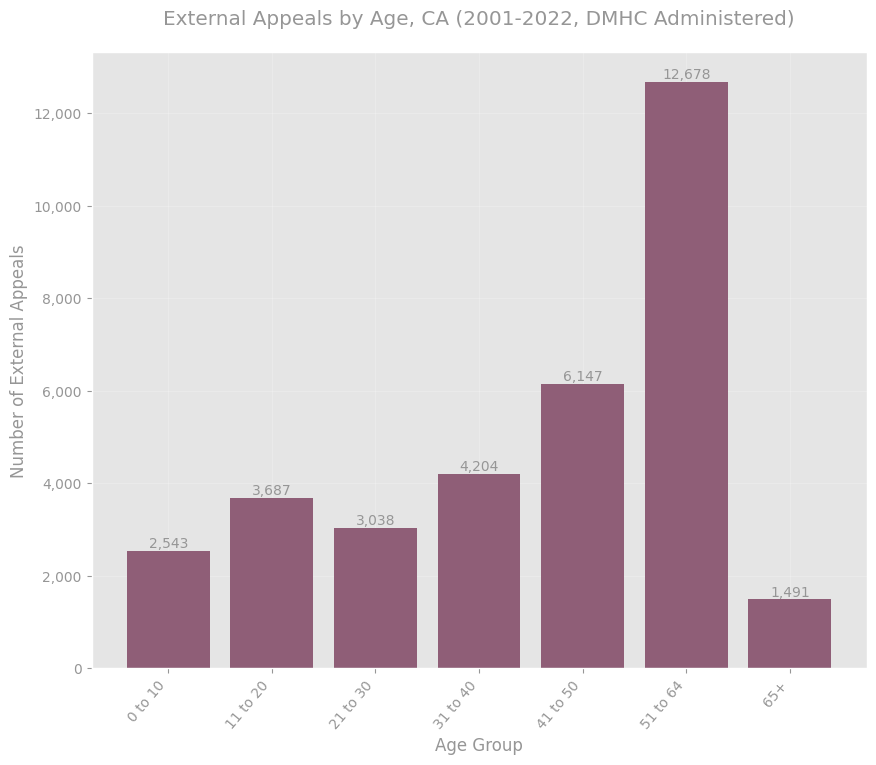

In [59]:
cat_vals = df["AgeRange"].value_counts()
bar_names, bar_vals = list(cat_vals.index), cat_vals.values
sort_order = np.argsort(bar_names)
bar_names = [bar_names[x] for x in sort_order]
bar_vals = [bar_vals[x] for x in sort_order]
title = "External Appeals by Age, CA (2001-2022, DMHC Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Age Group"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_age.png"),
    bar_label=True,
    figsize=(10, 8),
)

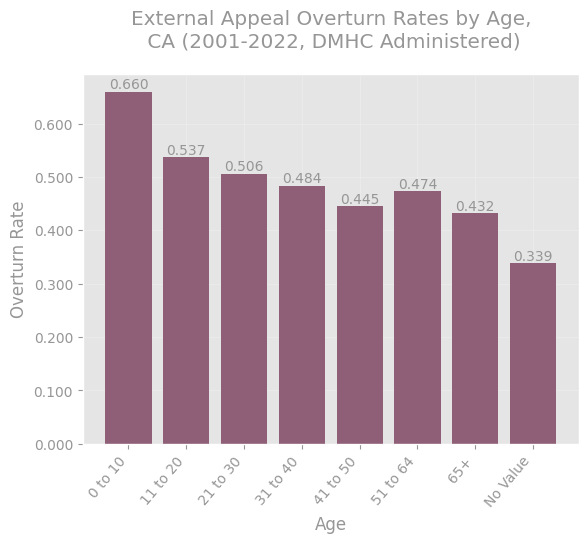

In [60]:
df["AgeRange"] = df["AgeRange"].fillna("No Value")
(cats, overturn_rates) = zip(
    *get_overturn_rates_by_categorical_col(
        df,
        "AgeRange",
        outcome_col_name="Determination",
        overturn_val="Overturned Decision of Health Plan",
    )
)

title = "External Appeal Overturn Rates by Age,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "Overturn Rate"
cat_axis_label = "Age"
bar_names = cats
bar_vals = overturn_rates

plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_age.png"),
    bar_label=True,
    # figsize=(10, 8),
    int_vals=False
)

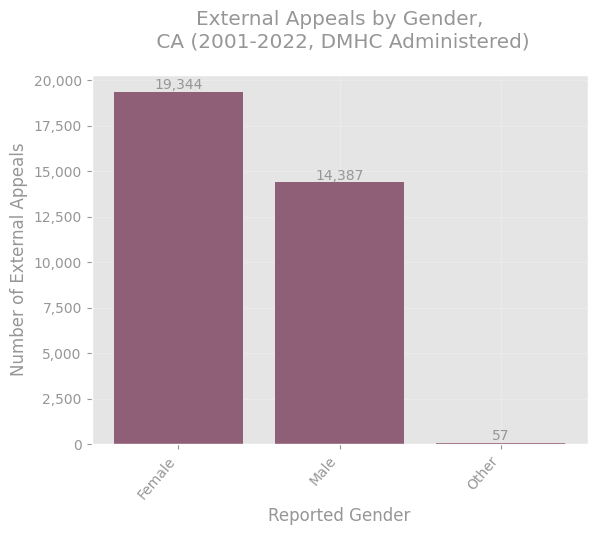

In [61]:
cat_vals = df["PatientGender"].value_counts()
bar_names, bar_vals = list(cat_vals.index), cat_vals.values
title = "External Appeals by Gender,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Reported Gender"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_gender.png"),
    bar_label=True,
    # figsize=(10, 8),
)

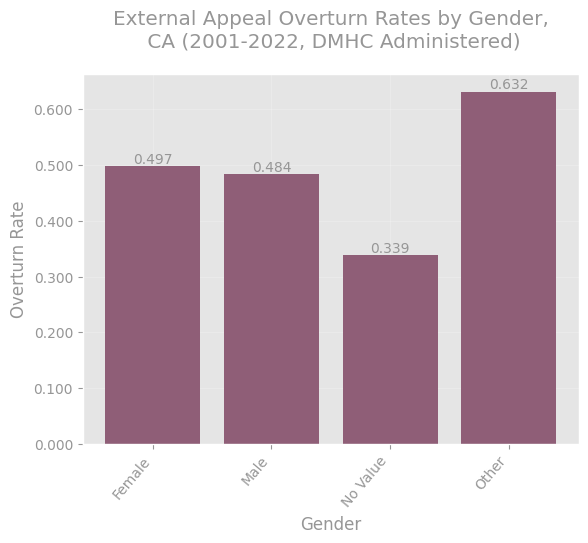

In [62]:
df["PatientGender"] = df["PatientGender"].fillna("No Value")
(cats, overturn_rates) = zip(
    *get_overturn_rates_by_categorical_col(
        df,
        "PatientGender",
        outcome_col_name="Determination",
        overturn_val="Overturned Decision of Health Plan",
    )
)

title = "External Appeal Overturn Rates by Gender,\n CA (2001-2022, DMHC Administered)"
val_axis_label = "Overturn Rate"
cat_axis_label = "Gender"
bar_names=cats
bar_vals = overturn_rates

plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_gender.png"),
    bar_label=True,
    # figsize=(10, 8),
    int_vals=False
)

In [63]:
name = "Crohn's Disease"
pattern = r"\b(?:crohn)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in [
            "DiagnosisCategory",
            "DiagnosisSubCategory",
            "TreatmentCategory",
            "TreatmentSubCategory",
            # "Findings"
        ]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Determination",
    overturn_val="Overturned Decision of Health Plan",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Crohn's Disease: 78.89% overturn rate among 90 external appeals.

Data sample:


ReferenceID  ReportYear     DiagnosisCategory DiagnosisSubCategory   
26046  MN19-31564        2019  Digestive System/ GI      Crohn's Disease  \
26120  MN19-31485        2019  Digestive System/ GI      Crohn's Disease   
26211  MN19-31686        2019  Digestive System/ GI      Crohn's Disease   
26281  MN19-31610        2019  Digestive System/ GI      Crohn's Disease   
26306  MN19-31672        2019  Digestive System/ GI      Crohn's Disease   

      TreatmentCategory TreatmentSubCategory   
26046          Pharmacy      Digestion/GI Rx  \
26120          Pharmacy          Antibiotics   
26211   Pain Management  Viscosupp Injection   
26281          Pharmacy      Digestion/GI Rx   
26306          Pharmacy            Biologics   

                            Determination               Type  AgeRange   
26046  Overturned Decision of Health Plan  Medical Necessity  11 to 20  \
26120  Overturned Decision of Health Plan  Medical Necessity   0 to 10   
26211      Upheld Decision of Health Plan  Medical Necessity  31 to 40   
26281  Overturned Decision of Health Plan  Medical Necessity  21 to 30   
26306  Overturned Decision of Health Plan  Medical Necessity  31 to 40   

      PatientGender    IMRType  DaysToReview  DaysToAdopt   
26046          Male  Expedited           4.0            8  \
26120          Male  Expedited           2.0           25   
26211        Female   Standard          28.0           55   
26281        Female  Expedited           2.0            8   
26306          Male  Expedited           4.0           11   

                                                Findings  
26046  Nature of Statutory Criteria/Case Summary: The...  
26120  The parent of an enrollee has requested author...  
26211  Nature of Statutory Criteria/Case Summary: The...  
26281  The patient has requested authorization and co...  
26306  Nature of Statutory Criteria/Case Summary: An ...

In [64]:
name = "Ulcerative Colitis"
pattern = r"\b(?:uc|ulcerative colitis)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in [
            "DiagnosisCategory",
            "DiagnosisSubCategory",
            "TreatmentCategory",
            "TreatmentSubCategory",
            # "Findings"
        ]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Determination",
    overturn_val="Overturned Decision of Health Plan",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Ulcerative Colitis: 55.56% overturn rate among 108 external appeals.

Data sample:


ReferenceID  ReportYear     DiagnosisCategory DiagnosisSubCategory   
870    EI03-2985        2003  Digestive System/ GI   Ulcerative Colitis  \
1533   EI04-3853        2004  Digestive System/ GI   Ulcerative Colitis   
4681   MN07-7377        2007  Digestive System/ GI   Ulcerative Colitis   
4695   MN07-7490        2007  Digestive System/ GI   Ulcerative Colitis   
5534   MN07-6582        2007  Digestive System/ GI   Ulcerative Colitis   

     TreatmentCategory  TreatmentSubCategory   
870           Pharmacy                 Other  \
1533          Pharmacy    Invest Tx Protocol   
4681          Pharmacy  Formulary v Non Form   
4695     Diag/ MD Eval     SCP Consult Refer   
5534    Alternative Tx           Acupuncture   

                           Determination                          Type   
870       Upheld Decision of Health Plan  Experimental/Investigational  \
1533      Upheld Decision of Health Plan  Experimental/Investigational   
4681  Overturned Decision of Health Plan             Medical Necessity   
4695  Overturned Decision of Health Plan             Medical Necessity   
5534      Upheld Decision of Health Plan             Medical Necessity   

      AgeRange PatientGender   IMRType  DaysToReview  DaysToAdopt   
870   51 to 64        Female  Standard          18.0           42  \
1533  31 to 40        Female  Standard          13.0           30   
4681  51 to 64        Female  Standard          34.0           65   
4695  51 to 64          Male  Standard          21.0           29   
5534  51 to 64        Female  Standard          21.0           57   

                                               Findings  
870   A female enrollee requested authorization and ...  
1533  Physician 1This is a patient with apparent lef...  
4681  A 64-year-old female enrollee has requested th...  
4695  A 58-year-old male enrollee has requested a re...  
5534  A 51-year-old female enrollee has requested ac...

In [65]:
name = "Gender Identity"
pattern = r"\b(?:gender|affirming|transgender|dysphoria|sex change)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in [
            "DiagnosisCategory",
            "DiagnosisSubCategory",
            "TreatmentCategory",
            "TreatmentSubCategory",
            # "Findings"
        ]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Determination",
    overturn_val="Overturned Decision of Health Plan",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Gender Identity: 81.65% overturn rate among 267 external appeals.

Data sample:


ReferenceID  ReportYear DiagnosisCategory DiagnosisSubCategory   
12806  MN13-15225        2013   Mental Disorder          Transgender  \
13013  EI13-15676        2013   Mental Disorder          Transgender   
13145  MN13-15501        2013   Mental Disorder          Transgender   
13565  MN13-15075        2013   Mental Disorder          Transgender   
13606  MN13-15055        2013   Mental Disorder          Transgender   

         TreatmentCategory TreatmentSubCategory   
12806        Gen Surg Proc                Other  \
13013             Pharmacy             Hormones   
13145  Elect/Therm/Radfreq                  TMS   
13565  Reconstr/Plast Proc                Other   
13606  Reconstr/Plast Proc                Other   

                            Determination                          Type   
12806      Upheld Decision of Health Plan             Medical Necessity  \
13013      Upheld Decision of Health Plan  Experimental/Investigational   
13145  Overturned Decision of Health Plan             Medical Necessity   
13565      Upheld Decision of Health Plan             Medical Necessity   
13606  Overturned Decision of Health Plan             Medical Necessity   

       AgeRange PatientGender    IMRType  DaysToReview  DaysToAdopt   
12806  41 to 50        Female   Standard          20.0           67  \
13013  51 to 64        Female   Standard          28.0           49   
13145  21 to 30          Male  Expedited           NaN           19   
13565  51 to 64        Female  Expedited           5.0           56   
13606  51 to 64          Male   Standard          19.0           48   

                                                Findings  
12806  A 50-year-old female enrollee has requested ge...  
13013  A 59-year-old female enrollee has requested ho...  
13145  A 27-year-old enrollee has requested transcran...  
13565  A 55-year-old female enrollee has requested ge...  
13606  A 57-year-old male enrollee has requested sexu...

In [66]:
name = "HIV/AIDS"
pattern = r"\b(?:HIV|AIDS)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in [
            "DiagnosisCategory",
            "DiagnosisSubCategory",
            "TreatmentCategory",
            "TreatmentSubCategory",
            # "Findings"
        ]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Determination",
    overturn_val="Overturned Decision of Health Plan",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

HIV/AIDS: 48.00% overturn rate among 75 external appeals.

Data sample:


ReferenceID  ReportYear   DiagnosisCategory DiagnosisSubCategory   
81    MN02-1211        2002  Infectious Disease             AIDS/HIV  \
153   MN02-1075        2002  Infectious Disease             AIDS/HIV   
368   MN02-1290        2002  Infectious Disease             AIDS/HIV   
606    MN02-975        2002  Infectious Disease             AIDS/HIV   
817   MN03-2930        2003  Infectious Disease             AIDS/HIV   

    TreatmentCategory TreatmentSubCategory   
81           Pharmacy      AIDS Wasting Tx  \
153          Pharmacy      AIDS Wasting Tx   
368          Pharmacy      AIDS Wasting Tx   
606          Pharmacy      AIDS Wasting Tx   
817          Pharmacy      AIDS Wasting Tx   

                          Determination               Type  AgeRange   
81   Overturned Decision of Health Plan  Medical Necessity  No Value  \
153  Overturned Decision of Health Plan  Medical Necessity  No Value   
368  Overturned Decision of Health Plan  Medical Necessity  No Value   
606  Overturned Decision of Health Plan  Medical Necessity  No Value   
817  Overturned Decision of Health Plan  Medical Necessity  31 to 40   

    PatientGender   IMRType  DaysToReview  DaysToAdopt   
81       No Value  Standard          23.0           56  \
153      No Value  Standard          21.0           35   
368      No Value  Standard          21.0           55   
606      No Value  Standard          21.0           37   
817          Male  Standard          21.0           38   

                                              Findings  
81   A 36-year-old male enrollee requested authoriz...  
153  A 40-year-old male enrollee requested authoriz...  
368  A 41-year-old male enrollee requested authoriz...  
606  A 47-year-old male enrollee requested authoriz...  
817  A 34-year-old male enrollee requested authoriz...

In [67]:
# Average days to review among expedited?

In [68]:
df.head()

ReferenceID  ReportYear     DiagnosisCategory DiagnosisSubCategory   
0    EI01-591        2001     OB-GYN/ Pregnancy             Fibroids  \
1   EI01-2846        2001                Cancer                Other   
2    EI01-711        2001        Morbid Obesity                Other   
3    MN01-710        2001  Orth/Musculoskeletal                Other   
4    MN01-679        2001  Cardiac/Circ Problem                Other   

     TreatmentCategory TreatmentSubCategory                   Determination   
0          Ob-Gyn Proc     Uter Art Emboliz  Upheld Decision of Health Plan  \
1          Cancer Care   Investigational Tx  Upheld Decision of Health Plan   
2        Gen Surg Proc    Bariatric Surgery  Upheld Decision of Health Plan   
3      Orthopedic Proc      Hip Replacement  Upheld Decision of Health Plan   
4  Rehab/Svcs SNF Inpt                Other  Upheld Decision of Health Plan   

                           Type  AgeRange PatientGender    IMRType   
0  Experimental/Investigational  No Value      No Value  Expedited  \
1  Experimental/Investigational  21 to 30        Female  Expedited   
2  Experimental/Investigational  No Value      No Value   Standard   
3             Medical Necessity  No Value      No Value   Standard   
4             Medical Necessity  No Value      No Value  Expedited   

   DaysToReview  DaysToAdopt   
0           7.0           21  \
1           7.0           14   
2          21.0           16   
3          21.0           16   
4           4.0           29   

                                            Findings  
0  A 51-year-old female enrollee requested author...  
1  A thirty year-old female diagnosed with an epe...  
2  A 49-year-old female enrollee requested author...  
3  A 45-year-old male enrollee requested authoriz...  
4  A 55-year-old male enrollee requested authoriz...

In [69]:
# Export json data for visualization
export_df = df[["ReportYear", "DiagnosisCategory", "DiagnosisSubCategory", "TreatmentCategory", "TreatmentSubCategory", "Determination", "IMRType", "DaysToReview", "DaysToAdopt", "AgeRange", "PatientGender"]]
export_df.to_json(path_or_buf=os.path.join(OUTPUT_DATA_DIR, "dmhc.json"), orient="records")